### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 600
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 40  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")




Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [00:44<61:12:04, 44.07s/it]

Entrenando:   0%|          | 2/5000 [01:36<68:03:53, 49.03s/it]

Entrenando:   0%|          | 3/5000 [02:28<70:05:11, 50.49s/it]

Entrenando:   0%|          | 4/5000 [03:28<75:05:00, 54.10s/it]

Entrenando:   0%|          | 5/5000 [04:27<77:20:38, 55.74s/it]

Entrenando:   0%|          | 6/5000 [05:39<84:57:28, 61.24s/it]

Entrenando:   0%|          | 7/5000 [06:54<91:13:26, 65.77s/it]

Entrenando:   0%|          | 8/5000 [08:02<92:09:58, 66.47s/it]

Entrenando:   0%|          | 9/5000 [09:12<93:54:57, 67.74s/it]

Entrenando:   0%|          | 10/5000 [10:21<94:33:50, 68.22s/it]

Entrenando:   0%|          | 11/5000 [11:28<93:49:50, 67.71s/it]

Entrenando:   0%|          | 12/5000 [12:41<96:05:56, 69.36s/it]

Entrenando:   0%|          | 13/5000 [13:47<94:47:54, 68.43s/it]

Entrenando:   0%|          | 14/5000 [15:01<97:08:01, 70.13s/it]

Entrenando:   0%|          | 15/5000 [16:19<100:02:18, 72.24s/it]

Entrenando:   0%|          | 16/5000 [17:56<110:37:32, 79.91s/it]

Entrenando:   0%|          | 17/5000 [19:42<121:17:50, 87.63s/it]

Entrenando:   0%|          | 18/5000 [21:27<128:37:17, 92.94s/it]

Entrenando:   0%|          | 19/5000 [23:11<133:07:13, 96.21s/it]

Entrenando:   0%|          | 20/5000 [24:54<135:44:38, 98.13s/it]

Entrenando:   0%|          | 21/5000 [26:51<143:41:51, 103.90s/it]

Entrenando:   0%|          | 22/5000 [28:52<150:39:56, 108.96s/it]

Entrenando:   0%|          | 23/5000 [30:45<152:29:21, 110.30s/it]

Entrenando:   0%|          | 24/5000 [32:40<154:24:30, 111.71s/it]

Entrenando:   0%|          | 25/5000 [34:31<154:06:39, 111.52s/it]

Entrenando:   1%|          | 26/5000 [36:25<154:55:34, 112.13s/it]

Entrenando:   1%|          | 27/5000 [38:09<151:38:56, 109.78s/it]

Entrenando:   1%|          | 28/5000 [40:30<164:42:45, 119.26s/it]

Entrenando:   1%|          | 29/5000 [42:53<174:30:20, 126.38s/it]

Entrenando:   1%|          | 30/5000 [45:11<179:02:30, 129.69s/it]

Entrenando:   1%|          | 31/5000 [47:25<180:52:10, 131.04s/it]

Entrenando:   1%|          | 32/5000 [49:40<182:32:31, 132.28s/it]

Entrenando:   1%|          | 33/5000 [51:57<184:14:20, 133.53s/it]

Entrenando:   1%|          | 34/5000 [54:14<185:44:33, 134.65s/it]

Entrenando:   1%|          | 35/5000 [56:29<186:05:12, 134.93s/it]

Entrenando:   1%|          | 36/5000 [58:45<186:25:30, 135.20s/it]

Entrenando:   1%|          | 37/5000 [1:01:03<187:12:43, 135.80s/it]

Entrenando:   1%|          | 38/5000 [1:03:17<186:28:03, 135.28s/it]

Entrenando:   1%|          | 39/5000 [1:05:34<187:06:00, 135.77s/it]

Entrenando:   1%|          | 40/5000 [1:07:48<186:34:49, 135.42s/it]

Entrenando:   1%|          | 41/5000 [1:10:08<188:24:53, 136.78s/it]

Entrenando:   1%|          | 42/5000 [1:12:34<192:03:47, 139.46s/it]

Entrenando:   1%|          | 43/5000 [1:14:54<192:10:15, 139.56s/it]

Entrenando:   1%|          | 44/5000 [1:17:13<192:15:36, 139.66s/it]

Entrenando:   1%|          | 45/5000 [1:19:36<193:31:19, 140.60s/it]

Entrenando:   1%|          | 46/5000 [1:22:00<194:56:34, 141.66s/it]

Entrenando:   1%|          | 47/5000 [1:24:28<197:33:00, 143.59s/it]

Entrenando:   1%|          | 48/5000 [1:26:50<196:50:16, 143.10s/it]

Entrenando:   1%|          | 49/5000 [1:29:09<194:57:06, 141.75s/it]

Entrenando:   1%|          | 50/5000 [1:31:14<187:59:12, 136.72s/it]

Iter  50: train_loss=8.3022, val_loss=8.5603, train_suc=0.355, train_err=0.178, train_inc=0.467 | val_suc=0.374, val_err=0.176, val_inc=0.450


Entrenando:   1%|          | 51/5000 [1:33:13<180:42:42, 131.45s/it]

Entrenando:   1%|          | 52/5000 [1:35:12<175:23:38, 127.61s/it]

Entrenando:   1%|          | 53/5000 [1:37:08<170:45:08, 124.26s/it]

Entrenando:   1%|          | 54/5000 [1:38:46<159:49:39, 116.33s/it]

Entrenando:   1%|          | 55/5000 [1:40:35<156:47:14, 114.14s/it]

Entrenando:   1%|          | 56/5000 [1:42:26<155:18:23, 113.09s/it]

Entrenando:   1%|          | 57/5000 [1:44:14<153:07:35, 111.52s/it]

Entrenando:   1%|          | 58/5000 [1:46:11<155:32:22, 113.30s/it]

Entrenando:   1%|          | 59/5000 [1:47:59<153:23:27, 111.76s/it]

Entrenando:   1%|          | 60/5000 [1:49:38<147:48:37, 107.72s/it]

Entrenando:   1%|          | 61/5000 [1:51:23<146:49:54, 107.02s/it]

Entrenando:   1%|          | 62/5000 [1:52:59<142:12:35, 103.68s/it]

Entrenando:   1%|▏         | 63/5000 [1:54:37<139:44:01, 101.89s/it]

Entrenando:   1%|▏         | 64/5000 [1:56:13<137:33:37, 100.33s/it]

Entrenando:   1%|▏         | 65/5000 [1:57:52<136:43:55, 99.74s/it] 

Entrenando:   1%|▏         | 66/5000 [1:59:40<140:25:57, 102.46s/it]

Entrenando:   1%|▏         | 67/5000 [2:01:19<138:59:58, 101.44s/it]

Entrenando:   1%|▏         | 68/5000 [2:03:11<143:08:09, 104.48s/it]

Entrenando:   1%|▏         | 69/5000 [2:05:05<146:48:26, 107.18s/it]

Entrenando:   1%|▏         | 70/5000 [2:06:55<148:07:24, 108.16s/it]

Entrenando:   1%|▏         | 71/5000 [2:08:34<144:17:22, 105.38s/it]

Entrenando:   1%|▏         | 72/5000 [2:10:21<144:59:55, 105.92s/it]

Entrenando:   1%|▏         | 73/5000 [2:12:03<143:26:34, 104.81s/it]

Entrenando:   1%|▏         | 74/5000 [2:13:39<139:46:54, 102.15s/it]

Entrenando:   2%|▏         | 75/5000 [2:15:15<137:03:59, 100.19s/it]

Entrenando:   2%|▏         | 76/5000 [2:16:50<134:51:48, 98.60s/it] 

Entrenando:   2%|▏         | 77/5000 [2:18:24<133:15:54, 97.45s/it]

Entrenando:   2%|▏         | 78/5000 [2:19:58<131:40:31, 96.31s/it]

Entrenando:   2%|▏         | 79/5000 [2:21:32<130:42:42, 95.62s/it]

Entrenando:   2%|▏         | 80/5000 [2:23:06<129:51:42, 95.02s/it]

Entrenando:   2%|▏         | 81/5000 [2:24:37<128:15:46, 93.87s/it]

Entrenando:   2%|▏         | 82/5000 [2:26:10<127:53:04, 93.61s/it]

Entrenando:   2%|▏         | 83/5000 [2:27:43<127:34:32, 93.40s/it]

Entrenando:   2%|▏         | 84/5000 [2:29:10<124:55:53, 91.49s/it]

Entrenando:   2%|▏         | 85/5000 [2:30:34<121:44:33, 89.17s/it]

Entrenando:   2%|▏         | 86/5000 [2:31:56<118:43:29, 86.98s/it]

Entrenando:   2%|▏         | 87/5000 [2:33:18<116:51:16, 85.63s/it]

Entrenando:   2%|▏         | 88/5000 [2:34:38<114:42:17, 84.07s/it]

Entrenando:   2%|▏         | 89/5000 [2:35:55<111:48:15, 81.96s/it]

Entrenando:   2%|▏         | 90/5000 [2:37:13<109:55:12, 80.59s/it]

Entrenando:   2%|▏         | 91/5000 [2:38:31<108:44:25, 79.74s/it]

Entrenando:   2%|▏         | 92/5000 [2:39:50<108:36:12, 79.66s/it]

Entrenando:   2%|▏         | 93/5000 [2:41:06<107:03:08, 78.54s/it]

Entrenando:   2%|▏         | 94/5000 [2:42:11<101:40:51, 74.61s/it]

Entrenando:   2%|▏         | 95/5000 [2:43:19<98:40:56, 72.43s/it] 

Entrenando:   2%|▏         | 96/5000 [2:44:33<99:18:12, 72.90s/it]

Entrenando:   2%|▏         | 97/5000 [2:45:35<94:53:05, 69.67s/it]

Entrenando:   2%|▏         | 98/5000 [2:46:41<93:25:13, 68.61s/it]

Entrenando:   2%|▏         | 99/5000 [2:47:51<94:06:45, 69.13s/it]

Entrenando:   2%|▏         | 100/5000 [2:49:00<93:46:09, 68.89s/it]

Iter 100: train_loss=3.0801, val_loss=3.0286, train_suc=0.416, train_err=0.034, train_inc=0.550 | val_suc=0.435, val_err=0.035, val_inc=0.530
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [2:50:07<93:06:18, 68.42s/it]

Entrenando:   2%|▏         | 102/5000 [2:51:19<94:22:57, 69.37s/it]

Entrenando:   2%|▏         | 103/5000 [2:52:33<96:32:24, 70.97s/it]

Entrenando:   2%|▏         | 104/5000 [2:53:45<96:48:31, 71.18s/it]

Entrenando:   2%|▏         | 105/5000 [2:54:55<96:14:10, 70.78s/it]

Entrenando:   2%|▏         | 106/5000 [2:56:03<95:00:43, 69.89s/it]

Entrenando:   2%|▏         | 107/5000 [2:57:20<98:07:08, 72.19s/it]

Entrenando:   2%|▏         | 108/5000 [2:58:34<98:53:42, 72.78s/it]

Entrenando:   2%|▏         | 109/5000 [2:59:45<97:53:28, 72.05s/it]

Entrenando:   2%|▏         | 110/5000 [3:00:56<97:21:43, 71.68s/it]

Entrenando:   2%|▏         | 111/5000 [3:02:08<97:41:46, 71.94s/it]

Entrenando:   2%|▏         | 112/5000 [3:03:19<97:18:57, 71.67s/it]

Entrenando:   2%|▏         | 113/5000 [3:04:22<93:29:40, 68.87s/it]

Entrenando:   2%|▏         | 114/5000 [3:05:37<96:06:51, 70.82s/it]

Entrenando:   2%|▏         | 115/5000 [3:06:53<98:04:50, 72.28s/it]

Entrenando:   2%|▏         | 116/5000 [3:08:07<99:07:35, 73.07s/it]

Entrenando:   2%|▏         | 117/5000 [3:09:18<98:03:30, 72.29s/it]

Entrenando:   2%|▏         | 118/5000 [3:10:26<96:17:30, 71.01s/it]

Entrenando:   2%|▏         | 119/5000 [3:11:39<97:17:09, 71.75s/it]

Entrenando:   2%|▏         | 120/5000 [3:12:49<96:18:59, 71.05s/it]

Entrenando:   2%|▏         | 121/5000 [3:13:57<95:13:52, 70.27s/it]

Entrenando:   2%|▏         | 122/5000 [3:15:09<95:43:31, 70.65s/it]

Entrenando:   2%|▏         | 123/5000 [3:16:26<98:12:47, 72.50s/it]

Entrenando:   2%|▏         | 124/5000 [3:17:35<96:58:15, 71.59s/it]

Entrenando:   2%|▎         | 125/5000 [3:18:47<97:09:15, 71.74s/it]

Entrenando:   3%|▎         | 126/5000 [3:20:01<98:07:16, 72.47s/it]

Entrenando:   3%|▎         | 127/5000 [3:21:14<98:15:22, 72.59s/it]

Entrenando:   3%|▎         | 128/5000 [3:22:28<98:51:46, 73.05s/it]

Entrenando:   3%|▎         | 129/5000 [3:23:42<98:57:39, 73.14s/it]

Entrenando:   3%|▎         | 130/5000 [3:24:56<99:16:09, 73.38s/it]

Entrenando:   3%|▎         | 131/5000 [3:26:12<100:34:07, 74.36s/it]

Entrenando:   3%|▎         | 132/5000 [3:27:28<101:01:23, 74.71s/it]

Entrenando:   3%|▎         | 133/5000 [3:28:41<100:24:56, 74.27s/it]

Entrenando:   3%|▎         | 134/5000 [3:29:48<97:35:14, 72.20s/it] 

Entrenando:   3%|▎         | 135/5000 [3:30:55<95:05:52, 70.37s/it]

Entrenando:   3%|▎         | 136/5000 [3:32:09<96:50:25, 71.67s/it]

Entrenando:   3%|▎         | 137/5000 [3:33:22<97:09:33, 71.93s/it]

Entrenando:   3%|▎         | 138/5000 [3:34:34<97:18:29, 72.05s/it]

Entrenando:   3%|▎         | 139/5000 [3:35:45<96:54:28, 71.77s/it]

Entrenando:   3%|▎         | 140/5000 [3:36:56<96:22:29, 71.39s/it]

Entrenando:   3%|▎         | 141/5000 [3:38:02<94:12:13, 69.79s/it]

Entrenando:   3%|▎         | 142/5000 [3:39:11<94:04:11, 69.71s/it]

Entrenando:   3%|▎         | 143/5000 [3:40:20<93:31:20, 69.32s/it]

Entrenando:   3%|▎         | 144/5000 [3:41:30<93:46:35, 69.52s/it]

Entrenando:   3%|▎         | 145/5000 [3:42:50<98:11:45, 72.81s/it]

Entrenando:   3%|▎         | 146/5000 [3:44:08<100:13:09, 74.33s/it]

Entrenando:   3%|▎         | 147/5000 [3:45:13<96:15:37, 71.41s/it] 

Entrenando:   3%|▎         | 148/5000 [3:46:24<96:12:22, 71.38s/it]

Entrenando:   3%|▎         | 149/5000 [3:47:39<97:34:07, 72.41s/it]

Entrenando:   3%|▎         | 150/5000 [3:48:50<96:51:57, 71.90s/it]

Iter 150: train_loss=1.9059, val_loss=1.7742, train_suc=0.443, train_err=0.004, train_inc=0.553 | val_suc=0.463, val_err=0.004, val_inc=0.533


Entrenando:   3%|▎         | 151/5000 [3:49:57<95:06:58, 70.62s/it]

Entrenando:   3%|▎         | 152/5000 [3:51:09<95:39:45, 71.04s/it]

Entrenando:   3%|▎         | 153/5000 [3:52:21<96:02:18, 71.33s/it]

Entrenando:   3%|▎         | 154/5000 [3:53:24<92:27:45, 68.69s/it]

Entrenando:   3%|▎         | 155/5000 [3:54:41<95:43:18, 71.12s/it]

Entrenando:   3%|▎         | 156/5000 [3:56:02<99:42:20, 74.10s/it]

Entrenando:   3%|▎         | 157/5000 [3:57:22<102:19:16, 76.06s/it]

Entrenando:   3%|▎         | 158/5000 [3:58:38<102:22:09, 76.11s/it]

Entrenando:   3%|▎         | 159/5000 [3:59:59<103:57:22, 77.31s/it]

Entrenando:   3%|▎         | 160/5000 [4:01:06<100:05:27, 74.45s/it]

Entrenando:   3%|▎         | 161/5000 [4:02:18<98:47:44, 73.50s/it] 

Entrenando:   3%|▎         | 162/5000 [4:03:33<99:40:04, 74.16s/it]

Entrenando:   3%|▎         | 163/5000 [4:04:42<97:31:17, 72.58s/it]

Entrenando:   3%|▎         | 164/5000 [4:05:57<98:33:28, 73.37s/it]

Entrenando:   3%|▎         | 165/5000 [4:07:13<99:28:14, 74.06s/it]

Entrenando:   3%|▎         | 166/5000 [4:08:27<99:23:29, 74.02s/it]

Entrenando:   3%|▎         | 167/5000 [4:09:41<99:27:21, 74.08s/it]

Entrenando:   3%|▎         | 168/5000 [4:10:52<98:03:46, 73.06s/it]

Entrenando:   3%|▎         | 169/5000 [4:12:02<96:45:58, 72.11s/it]

Entrenando:   3%|▎         | 170/5000 [4:13:15<97:02:12, 72.33s/it]

Entrenando:   3%|▎         | 171/5000 [4:14:29<97:59:38, 73.05s/it]

Entrenando:   3%|▎         | 172/5000 [4:15:42<97:57:15, 73.04s/it]

Entrenando:   3%|▎         | 173/5000 [4:16:52<96:27:21, 71.94s/it]

Entrenando:   3%|▎         | 174/5000 [4:18:03<96:09:05, 71.73s/it]

Entrenando:   4%|▎         | 175/5000 [4:19:12<94:55:35, 70.83s/it]

Entrenando:   4%|▎         | 176/5000 [4:20:21<94:12:09, 70.30s/it]

Entrenando:   4%|▎         | 177/5000 [4:21:33<95:05:20, 70.98s/it]

Entrenando:   4%|▎         | 178/5000 [4:22:39<92:57:35, 69.40s/it]

Entrenando:   4%|▎         | 179/5000 [4:23:59<97:11:57, 72.58s/it]

Entrenando:   4%|▎         | 180/5000 [4:25:14<97:56:15, 73.15s/it]

Entrenando:   4%|▎         | 181/5000 [4:26:25<97:23:51, 72.76s/it]

Entrenando:   4%|▎         | 182/5000 [4:27:37<96:46:43, 72.31s/it]

Entrenando:   4%|▎         | 183/5000 [4:28:59<100:40:11, 75.24s/it]

Entrenando:   4%|▎         | 184/5000 [4:30:08<98:13:16, 73.42s/it] 

Entrenando:   4%|▎         | 185/5000 [4:31:28<101:02:19, 75.54s/it]

Entrenando:   4%|▎         | 186/5000 [4:32:43<100:40:52, 75.29s/it]

Entrenando:   4%|▎         | 187/5000 [4:33:46<95:37:12, 71.52s/it] 

Entrenando:   4%|▍         | 188/5000 [4:35:00<96:33:59, 72.24s/it]

Entrenando:   4%|▍         | 189/5000 [4:36:16<98:04:15, 73.39s/it]

Entrenando:   4%|▍         | 190/5000 [4:37:25<96:20:00, 72.10s/it]

Entrenando:   4%|▍         | 191/5000 [4:38:38<96:44:13, 72.42s/it]

Entrenando:   4%|▍         | 192/5000 [4:39:53<97:50:22, 73.26s/it]

Entrenando:   4%|▍         | 193/5000 [4:41:07<97:56:19, 73.35s/it]

Entrenando:   4%|▍         | 194/5000 [4:42:16<96:26:55, 72.25s/it]

Entrenando:   4%|▍         | 195/5000 [4:43:34<98:22:02, 73.70s/it]

Entrenando:   4%|▍         | 196/5000 [4:44:47<98:13:53, 73.61s/it]

Entrenando:   4%|▍         | 197/5000 [4:46:05<99:59:21, 74.95s/it]

Entrenando:   4%|▍         | 198/5000 [4:47:12<96:55:36, 72.66s/it]

Entrenando:   4%|▍         | 199/5000 [4:48:27<97:40:00, 73.23s/it]

Entrenando:   4%|▍         | 200/5000 [4:49:40<97:39:25, 73.24s/it]

Iter 200: train_loss=1.7464, val_loss=1.6245, train_suc=0.448, train_err=0.001, train_inc=0.552 | val_suc=0.468, val_err=0.001, val_inc=0.531
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [4:50:47<95:00:49, 71.28s/it]

Entrenando:   4%|▍         | 202/5000 [4:51:56<93:57:22, 70.50s/it]

Entrenando:   4%|▍         | 203/5000 [4:53:02<92:23:34, 69.34s/it]

Entrenando:   4%|▍         | 204/5000 [4:54:15<93:33:01, 70.22s/it]

Entrenando:   4%|▍         | 205/5000 [4:55:35<97:32:25, 73.23s/it]

Entrenando:   4%|▍         | 206/5000 [4:57:00<102:12:23, 76.75s/it]

Entrenando:   4%|▍         | 207/5000 [4:59:08<122:41:58, 92.16s/it]

Entrenando:   4%|▍         | 208/5000 [5:01:24<140:12:14, 105.33s/it]

Entrenando:   4%|▍         | 209/5000 [5:03:32<149:23:42, 112.26s/it]

Entrenando:   4%|▍         | 210/5000 [5:05:39<155:10:42, 116.63s/it]

Entrenando:   4%|▍         | 211/5000 [5:07:45<158:51:29, 119.42s/it]

Entrenando:   4%|▍         | 212/5000 [5:09:50<161:02:14, 121.08s/it]

Entrenando:   4%|▍         | 213/5000 [5:11:55<162:32:53, 122.24s/it]

Entrenando:   4%|▍         | 214/5000 [5:13:59<163:20:08, 122.86s/it]

Entrenando:   4%|▍         | 215/5000 [5:16:06<165:01:05, 124.15s/it]

Entrenando:   4%|▍         | 216/5000 [5:18:12<165:35:11, 124.61s/it]

Entrenando:   4%|▍         | 217/5000 [5:20:08<162:08:38, 122.04s/it]

Entrenando:   4%|▍         | 218/5000 [5:22:08<161:05:24, 121.27s/it]

Entrenando:   4%|▍         | 219/5000 [5:24:11<161:59:34, 121.98s/it]

Entrenando:   4%|▍         | 220/5000 [5:26:14<162:05:50, 122.08s/it]

Entrenando:   4%|▍         | 221/5000 [5:28:16<162:14:43, 122.22s/it]

Entrenando:   4%|▍         | 222/5000 [5:30:24<164:37:54, 124.04s/it]

Entrenando:   4%|▍         | 223/5000 [5:32:35<167:10:24, 125.98s/it]

Entrenando:   4%|▍         | 224/5000 [5:34:51<171:01:37, 128.91s/it]

Entrenando:   4%|▍         | 225/5000 [5:36:56<169:30:52, 127.80s/it]

Entrenando:   5%|▍         | 226/5000 [5:39:01<168:13:56, 126.86s/it]

Entrenando:   5%|▍         | 227/5000 [5:41:19<172:53:27, 130.40s/it]

Entrenando:   5%|▍         | 228/5000 [5:43:32<173:50:46, 131.15s/it]

Entrenando:   5%|▍         | 229/5000 [5:45:38<171:49:25, 129.65s/it]

Entrenando:   5%|▍         | 230/5000 [5:47:51<173:08:47, 130.68s/it]

Entrenando:   5%|▍         | 231/5000 [5:50:04<174:02:59, 131.39s/it]

Entrenando:   5%|▍         | 232/5000 [5:52:16<173:55:52, 131.32s/it]

Entrenando:   5%|▍         | 233/5000 [5:54:22<171:57:21, 129.86s/it]

Entrenando:   5%|▍         | 234/5000 [5:56:29<170:36:31, 128.87s/it]

Entrenando:   5%|▍         | 235/5000 [5:58:38<170:57:41, 129.16s/it]

Entrenando:   5%|▍         | 236/5000 [6:00:52<172:39:59, 130.48s/it]

Entrenando:   5%|▍         | 237/5000 [6:03:09<175:09:23, 132.39s/it]

Entrenando:   5%|▍         | 238/5000 [6:05:19<174:18:44, 131.78s/it]

Entrenando:   5%|▍         | 239/5000 [6:07:24<171:36:31, 129.76s/it]

Entrenando:   5%|▍         | 240/5000 [6:09:27<168:49:50, 127.69s/it]

Entrenando:   5%|▍         | 241/5000 [6:11:17<161:40:56, 122.31s/it]

Entrenando:   5%|▍         | 242/5000 [6:13:09<157:33:48, 119.22s/it]

Entrenando:   5%|▍         | 243/5000 [6:15:00<154:22:14, 116.82s/it]

Entrenando:   5%|▍         | 244/5000 [6:16:46<149:54:22, 113.47s/it]

Entrenando:   5%|▍         | 245/5000 [6:18:37<148:50:29, 112.69s/it]

Entrenando:   5%|▍         | 246/5000 [6:20:20<145:13:02, 109.97s/it]

Entrenando:   5%|▍         | 247/5000 [6:21:58<140:19:15, 106.28s/it]

Entrenando:   5%|▍         | 248/5000 [6:23:40<138:31:23, 104.94s/it]

Entrenando:   5%|▍         | 249/5000 [6:25:13<133:52:48, 101.45s/it]

Entrenando:   5%|▌         | 250/5000 [6:26:50<131:56:42, 100.00s/it]

Iter 250: train_loss=1.5349, val_loss=1.6018, train_suc=0.449, train_err=0.000, train_inc=0.550 | val_suc=0.470, val_err=0.000, val_inc=0.530


Entrenando:   5%|▌         | 251/5000 [6:28:34<133:42:24, 101.36s/it]

Entrenando:   5%|▌         | 252/5000 [6:30:24<136:59:47, 103.87s/it]

Entrenando:   5%|▌         | 253/5000 [6:32:15<139:40:28, 105.93s/it]

Entrenando:   5%|▌         | 254/5000 [6:33:58<138:31:30, 105.08s/it]

Entrenando:   5%|▌         | 255/5000 [6:35:35<135:20:04, 102.68s/it]

Entrenando:   5%|▌         | 256/5000 [6:37:23<137:29:44, 104.34s/it]

Entrenando:   5%|▌         | 257/5000 [6:38:47<129:32:09, 98.32s/it] 

Entrenando:   5%|▌         | 258/5000 [6:40:10<123:32:30, 93.79s/it]

Entrenando:   5%|▌         | 259/5000 [6:41:39<121:14:53, 92.07s/it]

Entrenando:   5%|▌         | 260/5000 [6:43:09<120:30:54, 91.53s/it]

Entrenando:   5%|▌         | 261/5000 [6:44:32<117:14:49, 89.07s/it]

Entrenando:   5%|▌         | 262/5000 [6:45:55<114:46:34, 87.21s/it]

Entrenando:   5%|▌         | 263/5000 [6:47:18<113:00:27, 85.88s/it]

Entrenando:   5%|▌         | 264/5000 [6:48:40<111:43:23, 84.92s/it]

Entrenando:   5%|▌         | 265/5000 [6:50:06<111:55:12, 85.09s/it]

Entrenando:   5%|▌         | 266/5000 [6:51:36<113:40:44, 86.45s/it]

Entrenando:   5%|▌         | 267/5000 [6:53:04<114:30:46, 87.10s/it]

Entrenando:   5%|▌         | 268/5000 [6:54:26<112:33:20, 85.63s/it]

Entrenando:   5%|▌         | 269/5000 [6:55:51<112:15:19, 85.42s/it]

Entrenando:   5%|▌         | 270/5000 [6:57:15<111:22:44, 84.77s/it]

Entrenando:   5%|▌         | 271/5000 [6:58:33<108:44:32, 82.78s/it]

Entrenando:   5%|▌         | 272/5000 [6:59:55<108:31:27, 82.63s/it]

Entrenando:   5%|▌         | 273/5000 [7:01:14<107:00:52, 81.50s/it]

Entrenando:   5%|▌         | 274/5000 [7:02:32<105:40:22, 80.50s/it]

Entrenando:   6%|▌         | 275/5000 [7:03:54<106:03:20, 80.80s/it]

Entrenando:   6%|▌         | 276/5000 [7:05:11<104:50:22, 79.89s/it]

Entrenando:   6%|▌         | 277/5000 [7:06:28<103:44:49, 79.08s/it]

Entrenando:   6%|▌         | 278/5000 [7:07:49<104:22:17, 79.57s/it]

Entrenando:   6%|▌         | 279/5000 [7:08:59<100:36:59, 76.73s/it]

Entrenando:   6%|▌         | 280/5000 [7:10:04<95:57:53, 73.19s/it] 

Entrenando:   6%|▌         | 281/5000 [7:11:10<93:04:58, 71.01s/it]

Entrenando:   6%|▌         | 282/5000 [7:12:28<95:38:02, 72.97s/it]

Entrenando:   6%|▌         | 283/5000 [7:13:34<92:50:09, 70.85s/it]

Entrenando:   6%|▌         | 284/5000 [7:14:41<91:24:05, 69.77s/it]

Entrenando:   6%|▌         | 285/5000 [7:15:50<91:03:04, 69.52s/it]

Entrenando:   6%|▌         | 286/5000 [7:17:02<92:16:04, 70.46s/it]

Entrenando:   6%|▌         | 287/5000 [7:18:15<93:14:29, 71.22s/it]

Entrenando:   6%|▌         | 288/5000 [7:19:35<96:40:04, 73.86s/it]

Entrenando:   6%|▌         | 289/5000 [7:20:49<96:35:49, 73.82s/it]

Entrenando:   6%|▌         | 290/5000 [7:22:04<96:49:11, 74.00s/it]

Entrenando:   6%|▌         | 291/5000 [7:23:13<95:07:01, 72.72s/it]

Entrenando:   6%|▌         | 292/5000 [7:24:29<96:12:19, 73.56s/it]

Entrenando:   6%|▌         | 293/5000 [7:25:44<96:45:59, 74.01s/it]

Entrenando:   6%|▌         | 294/5000 [7:27:02<98:09:50, 75.09s/it]

Entrenando:   6%|▌         | 295/5000 [7:28:19<98:53:02, 75.66s/it]

Entrenando:   6%|▌         | 296/5000 [7:29:31<97:30:28, 74.62s/it]

Entrenando:   6%|▌         | 297/5000 [7:30:37<94:04:24, 72.01s/it]

Entrenando:   6%|▌         | 298/5000 [7:31:53<95:38:02, 73.22s/it]

Entrenando:   6%|▌         | 299/5000 [7:33:08<96:22:00, 73.80s/it]

Entrenando:   6%|▌         | 300/5000 [7:34:21<96:05:31, 73.60s/it]

Iter 300: train_loss=1.8287, val_loss=1.5876, train_suc=0.452, train_err=0.000, train_inc=0.548 | val_suc=0.473, val_err=0.000, val_inc=0.527
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [7:35:32<95:06:37, 72.87s/it]

Entrenando:   6%|▌         | 302/5000 [7:36:39<92:49:39, 71.13s/it]

Entrenando:   6%|▌         | 303/5000 [7:37:55<94:45:53, 72.63s/it]

Entrenando:   6%|▌         | 304/5000 [7:39:01<92:05:22, 70.60s/it]

Entrenando:   6%|▌         | 305/5000 [7:40:17<94:03:48, 72.13s/it]

Entrenando:   6%|▌         | 306/5000 [7:41:31<94:50:39, 72.74s/it]

Entrenando:   6%|▌         | 307/5000 [7:42:43<94:22:41, 72.40s/it]

Entrenando:   6%|▌         | 308/5000 [7:43:58<95:19:56, 73.15s/it]

Entrenando:   6%|▌         | 309/5000 [7:45:09<94:42:55, 72.69s/it]

Entrenando:   6%|▌         | 310/5000 [7:46:24<95:39:14, 73.42s/it]

Entrenando:   6%|▌         | 311/5000 [7:47:35<94:39:05, 72.67s/it]

Entrenando:   6%|▌         | 312/5000 [7:48:45<93:22:28, 71.70s/it]

Entrenando:   6%|▋         | 313/5000 [7:50:02<95:42:55, 73.52s/it]

Entrenando:   6%|▋         | 314/5000 [7:51:19<97:04:56, 74.58s/it]

Entrenando:   6%|▋         | 315/5000 [7:52:32<96:16:41, 73.98s/it]

Entrenando:   6%|▋         | 316/5000 [7:53:37<92:54:36, 71.41s/it]

Entrenando:   6%|▋         | 317/5000 [7:54:56<95:36:12, 73.49s/it]

Entrenando:   6%|▋         | 318/5000 [7:56:12<96:46:26, 74.41s/it]

Entrenando:   6%|▋         | 319/5000 [7:57:28<97:02:40, 74.63s/it]

Entrenando:   6%|▋         | 320/5000 [7:58:44<97:41:26, 75.15s/it]

Entrenando:   6%|▋         | 321/5000 [7:59:49<93:56:45, 72.28s/it]

Entrenando:   6%|▋         | 322/5000 [8:00:59<92:41:35, 71.33s/it]

Entrenando:   6%|▋         | 323/5000 [8:02:21<97:06:07, 74.74s/it]

Entrenando:   6%|▋         | 324/5000 [8:03:37<97:18:28, 74.92s/it]

Entrenando:   6%|▋         | 325/5000 [8:04:49<96:09:46, 74.05s/it]

Entrenando:   7%|▋         | 326/5000 [8:05:53<92:20:47, 71.13s/it]

Entrenando:   7%|▋         | 327/5000 [8:07:03<91:52:56, 70.78s/it]

Entrenando:   7%|▋         | 328/5000 [8:08:17<93:15:11, 71.86s/it]

Entrenando:   7%|▋         | 329/5000 [8:09:36<95:47:37, 73.83s/it]

Entrenando:   7%|▋         | 330/5000 [8:10:40<91:57:38, 70.89s/it]

Entrenando:   7%|▋         | 331/5000 [8:11:48<91:06:09, 70.24s/it]

Entrenando:   7%|▋         | 332/5000 [8:13:03<92:42:50, 71.50s/it]

Entrenando:   7%|▋         | 333/5000 [8:14:01<87:24:10, 67.42s/it]

Entrenando:   7%|▋         | 334/5000 [8:15:16<90:19:45, 69.69s/it]

Entrenando:   7%|▋         | 335/5000 [8:16:26<90:26:06, 69.79s/it]

Entrenando:   7%|▋         | 336/5000 [8:17:38<91:18:16, 70.48s/it]

Entrenando:   7%|▋         | 337/5000 [8:18:44<89:25:03, 69.03s/it]

Entrenando:   7%|▋         | 338/5000 [8:19:56<90:33:02, 69.92s/it]

Entrenando:   7%|▋         | 339/5000 [8:21:03<89:29:43, 69.12s/it]

Entrenando:   7%|▋         | 340/5000 [8:22:17<91:29:44, 70.68s/it]

Entrenando:   7%|▋         | 341/5000 [8:23:30<92:11:22, 71.23s/it]

Entrenando:   7%|▋         | 342/5000 [8:24:39<91:22:13, 70.62s/it]

Entrenando:   7%|▋         | 343/5000 [8:26:06<97:39:19, 75.49s/it]

Entrenando:   7%|▋         | 344/5000 [8:28:01<113:14:10, 87.55s/it]

Entrenando:   7%|▋         | 345/5000 [8:29:42<118:13:26, 91.43s/it]

Entrenando:   7%|▋         | 346/5000 [8:31:29<124:12:32, 96.08s/it]

Entrenando:   7%|▋         | 347/5000 [8:33:10<126:03:30, 97.53s/it]

Entrenando:   7%|▋         | 348/5000 [8:34:45<125:17:52, 96.96s/it]

Entrenando:   7%|▋         | 349/5000 [8:36:23<125:40:16, 97.27s/it]

Entrenando:   7%|▋         | 350/5000 [8:38:04<127:06:52, 98.41s/it]

Iter 350: train_loss=1.5754, val_loss=1.5607, train_suc=0.460, train_err=0.000, train_inc=0.540 | val_suc=0.482, val_err=0.000, val_inc=0.518


Entrenando:   7%|▋         | 351/5000 [8:39:55<131:58:04, 102.19s/it]

Entrenando:   7%|▋         | 352/5000 [8:41:51<137:09:36, 106.23s/it]

Entrenando:   7%|▋         | 353/5000 [8:43:36<136:36:11, 105.83s/it]

Entrenando:   7%|▋         | 354/5000 [8:45:13<132:59:46, 103.05s/it]

Entrenando:   7%|▋         | 355/5000 [8:46:53<132:07:03, 102.39s/it]

Entrenando:   7%|▋         | 356/5000 [8:48:41<134:08:34, 103.99s/it]

Entrenando:   7%|▋         | 357/5000 [8:50:23<133:14:49, 103.31s/it]

Entrenando:   7%|▋         | 358/5000 [8:52:14<136:07:56, 105.57s/it]

Entrenando:   7%|▋         | 359/5000 [8:54:02<137:05:15, 106.34s/it]

Entrenando:   7%|▋         | 360/5000 [8:55:51<138:00:11, 107.07s/it]

Entrenando:   7%|▋         | 361/5000 [8:57:34<136:21:24, 105.82s/it]

Entrenando:   7%|▋         | 362/5000 [8:59:15<134:29:52, 104.40s/it]

Entrenando:   7%|▋         | 363/5000 [9:01:05<136:45:29, 106.17s/it]

Entrenando:   7%|▋         | 364/5000 [9:02:55<138:18:48, 107.40s/it]

Entrenando:   7%|▋         | 365/5000 [9:04:36<135:43:16, 105.41s/it]

Entrenando:   7%|▋         | 366/5000 [9:06:27<137:46:02, 107.03s/it]

Entrenando:   7%|▋         | 367/5000 [9:08:17<139:00:54, 108.02s/it]

Entrenando:   7%|▋         | 368/5000 [9:10:05<138:48:28, 107.88s/it]

Entrenando:   7%|▋         | 369/5000 [9:11:45<135:54:19, 105.65s/it]

Entrenando:   7%|▋         | 370/5000 [9:13:38<138:33:35, 107.74s/it]

Entrenando:   7%|▋         | 371/5000 [9:15:15<134:34:54, 104.66s/it]

Entrenando:   7%|▋         | 372/5000 [9:16:53<131:46:09, 102.50s/it]

Entrenando:   7%|▋         | 373/5000 [9:18:30<129:50:11, 101.02s/it]

Entrenando:   7%|▋         | 374/5000 [9:20:14<130:41:53, 101.71s/it]

Entrenando:   8%|▊         | 375/5000 [9:21:50<128:27:58, 100.00s/it]

Entrenando:   8%|▊         | 376/5000 [9:23:39<131:56:04, 102.72s/it]

Entrenando:   8%|▊         | 377/5000 [9:25:41<139:40:36, 108.77s/it]

Entrenando:   8%|▊         | 378/5000 [9:27:34<141:11:58, 109.98s/it]

Entrenando:   8%|▊         | 379/5000 [9:29:19<139:02:27, 108.32s/it]

Entrenando:   8%|▊         | 380/5000 [9:31:02<136:59:24, 106.75s/it]

Entrenando:   8%|▊         | 381/5000 [9:32:47<136:33:18, 106.43s/it]

Entrenando:   8%|▊         | 382/5000 [9:34:27<133:55:06, 104.40s/it]

Entrenando:   8%|▊         | 383/5000 [9:36:21<137:26:39, 107.17s/it]

Entrenando:   8%|▊         | 384/5000 [9:38:06<136:45:46, 106.66s/it]

Entrenando:   8%|▊         | 385/5000 [9:39:58<138:35:57, 108.12s/it]

Entrenando:   8%|▊         | 386/5000 [9:41:45<138:24:18, 107.99s/it]

Entrenando:   8%|▊         | 387/5000 [9:43:36<139:26:55, 108.83s/it]

Entrenando:   8%|▊         | 388/5000 [9:45:26<139:36:51, 108.98s/it]

Entrenando:   8%|▊         | 389/5000 [9:47:16<140:07:21, 109.40s/it]

Entrenando:   8%|▊         | 390/5000 [9:49:09<141:19:21, 110.36s/it]

Entrenando:   8%|▊         | 391/5000 [9:50:53<139:07:59, 108.67s/it]

Entrenando:   8%|▊         | 392/5000 [9:52:54<143:45:17, 112.31s/it]

Entrenando:   8%|▊         | 393/5000 [9:54:53<146:22:45, 114.38s/it]

Entrenando:   8%|▊         | 394/5000 [9:56:34<141:01:15, 110.22s/it]

Entrenando:   8%|▊         | 395/5000 [9:58:21<139:56:27, 109.40s/it]

Entrenando:   8%|▊         | 396/5000 [10:00:04<137:12:49, 107.29s/it]

Entrenando:   8%|▊         | 397/5000 [10:01:49<136:17:04, 106.59s/it]

Entrenando:   8%|▊         | 398/5000 [10:03:37<137:06:26, 107.25s/it]

Entrenando:   8%|▊         | 399/5000 [10:05:21<135:48:51, 106.27s/it]

Entrenando:   8%|▊         | 400/5000 [10:07:08<135:58:55, 106.42s/it]

Iter 400: train_loss=1.5866, val_loss=1.5025, train_suc=0.479, train_err=0.000, train_inc=0.521 | val_suc=0.502, val_err=0.000, val_inc=0.498
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [10:08:59<137:34:42, 107.69s/it]

Entrenando:   8%|▊         | 402/5000 [10:10:47<137:45:20, 107.86s/it]

Entrenando:   8%|▊         | 403/5000 [10:12:43<140:56:21, 110.37s/it]

Entrenando:   8%|▊         | 404/5000 [10:14:39<143:06:07, 112.09s/it]

Entrenando:   8%|▊         | 405/5000 [10:16:26<140:46:45, 110.30s/it]

Entrenando:   8%|▊         | 406/5000 [10:18:10<138:39:17, 108.65s/it]

Entrenando:   8%|▊         | 407/5000 [10:20:00<138:53:17, 108.86s/it]

Entrenando:   8%|▊         | 408/5000 [10:21:55<141:24:03, 110.85s/it]

Entrenando:   8%|▊         | 409/5000 [10:23:29<134:54:17, 105.78s/it]

Entrenando:   8%|▊         | 410/5000 [10:25:06<131:37:29, 103.24s/it]

Entrenando:   8%|▊         | 411/5000 [10:26:44<129:34:05, 101.64s/it]

Entrenando:   8%|▊         | 412/5000 [10:28:21<127:25:57, 99.99s/it] 

Entrenando:   8%|▊         | 413/5000 [10:29:55<125:25:00, 98.43s/it]

Entrenando:   8%|▊         | 414/5000 [10:31:33<124:56:30, 98.08s/it]

Entrenando:   8%|▊         | 415/5000 [10:33:12<125:37:17, 98.63s/it]

Entrenando:   8%|▊         | 416/5000 [10:35:01<129:18:14, 101.55s/it]

Entrenando:   8%|▊         | 417/5000 [10:36:39<128:08:29, 100.66s/it]

Entrenando:   8%|▊         | 418/5000 [10:38:33<133:07:12, 104.59s/it]

Entrenando:   8%|▊         | 419/5000 [10:40:09<129:38:50, 101.88s/it]

Entrenando:   8%|▊         | 420/5000 [10:42:10<137:08:15, 107.79s/it]

Entrenando:   8%|▊         | 421/5000 [10:44:03<138:49:47, 109.15s/it]

Entrenando:   8%|▊         | 422/5000 [10:45:52<138:45:05, 109.11s/it]

Entrenando:   8%|▊         | 423/5000 [10:47:37<137:24:39, 108.08s/it]

Entrenando:   8%|▊         | 424/5000 [10:49:23<136:22:02, 107.28s/it]

Entrenando:   8%|▊         | 425/5000 [10:51:15<138:17:41, 108.82s/it]

Entrenando:   9%|▊         | 426/5000 [10:53:00<136:43:00, 107.60s/it]

Entrenando:   9%|▊         | 427/5000 [10:54:46<136:00:10, 107.07s/it]

Entrenando:   9%|▊         | 428/5000 [10:56:27<133:56:34, 105.47s/it]

Entrenando:   9%|▊         | 429/5000 [10:58:13<133:45:44, 105.35s/it]

Entrenando:   9%|▊         | 430/5000 [10:59:53<131:59:48, 103.98s/it]

Entrenando:   9%|▊         | 431/5000 [11:01:38<132:17:10, 104.23s/it]

Entrenando:   9%|▊         | 432/5000 [11:03:26<133:31:21, 105.23s/it]

Entrenando:   9%|▊         | 433/5000 [11:05:14<134:34:26, 106.08s/it]

Entrenando:   9%|▊         | 434/5000 [11:07:00<134:30:59, 106.06s/it]

Entrenando:   9%|▊         | 435/5000 [11:08:43<133:30:00, 105.28s/it]

Entrenando:   9%|▊         | 436/5000 [11:10:35<136:00:42, 107.28s/it]

Entrenando:   9%|▊         | 437/5000 [11:12:28<138:15:52, 109.08s/it]

Entrenando:   9%|▉         | 438/5000 [11:14:16<137:45:51, 108.71s/it]

Entrenando:   9%|▉         | 439/5000 [11:16:00<135:50:28, 107.22s/it]

Entrenando:   9%|▉         | 440/5000 [11:17:52<137:32:29, 108.59s/it]

Entrenando:   9%|▉         | 441/5000 [11:19:48<140:17:56, 110.79s/it]

Entrenando:   9%|▉         | 442/5000 [11:21:38<139:56:11, 110.52s/it]

Entrenando:   9%|▉         | 443/5000 [11:23:23<137:51:45, 108.91s/it]

Entrenando:   9%|▉         | 444/5000 [11:25:04<135:03:54, 106.72s/it]

Entrenando:   9%|▉         | 445/5000 [11:26:47<133:26:10, 105.46s/it]

Entrenando:   9%|▉         | 446/5000 [11:28:29<132:14:07, 104.53s/it]

Entrenando:   9%|▉         | 447/5000 [11:30:14<132:15:28, 104.57s/it]

Entrenando:   9%|▉         | 448/5000 [11:32:08<135:52:19, 107.46s/it]

Entrenando:   9%|▉         | 449/5000 [11:34:04<138:53:41, 109.87s/it]

Entrenando:   9%|▉         | 450/5000 [11:35:49<137:17:33, 108.63s/it]

Iter 450: train_loss=1.5355, val_loss=1.3537, train_suc=0.527, train_err=0.001, train_inc=0.472 | val_suc=0.555, val_err=0.000, val_inc=0.445


Entrenando:   9%|▉         | 451/5000 [11:37:34<135:48:14, 107.47s/it]

Entrenando:   9%|▉         | 452/5000 [11:39:18<134:34:11, 106.52s/it]

Entrenando:   9%|▉         | 453/5000 [11:40:57<131:33:45, 104.16s/it]

Entrenando:   9%|▉         | 454/5000 [11:42:45<133:00:01, 105.32s/it]

Entrenando:   9%|▉         | 455/5000 [11:44:39<136:02:01, 107.75s/it]

Entrenando:   9%|▉         | 456/5000 [11:46:28<136:31:04, 108.16s/it]

Entrenando:   9%|▉         | 457/5000 [11:48:07<133:04:39, 105.45s/it]

Entrenando:   9%|▉         | 458/5000 [11:49:45<130:25:34, 103.38s/it]

Entrenando:   9%|▉         | 459/5000 [11:51:26<129:27:39, 102.63s/it]

Entrenando:   9%|▉         | 460/5000 [11:53:10<129:59:45, 103.08s/it]

Entrenando:   9%|▉         | 461/5000 [11:54:55<130:24:05, 103.42s/it]

Entrenando:   9%|▉         | 462/5000 [11:56:48<134:04:39, 106.36s/it]

Entrenando:   9%|▉         | 463/5000 [11:58:37<134:59:58, 107.12s/it]

Entrenando:   9%|▉         | 464/5000 [12:00:20<133:38:19, 106.06s/it]

Entrenando:   9%|▉         | 465/5000 [12:02:09<134:29:46, 106.77s/it]

Entrenando:   9%|▉         | 466/5000 [12:04:00<136:01:07, 108.00s/it]

Entrenando:   9%|▉         | 467/5000 [12:05:51<137:07:36, 108.90s/it]

Entrenando:   9%|▉         | 468/5000 [12:07:35<135:20:58, 107.52s/it]

Entrenando:   9%|▉         | 469/5000 [12:09:21<134:45:43, 107.07s/it]

Entrenando:   9%|▉         | 470/5000 [12:11:01<132:12:09, 105.06s/it]

Entrenando:   9%|▉         | 471/5000 [12:12:39<129:18:22, 102.78s/it]

Entrenando:   9%|▉         | 472/5000 [12:14:18<128:01:13, 101.78s/it]

Entrenando:   9%|▉         | 473/5000 [12:15:56<126:34:53, 100.66s/it]

Entrenando:   9%|▉         | 474/5000 [12:17:34<125:23:26, 99.74s/it] 

Entrenando:  10%|▉         | 475/5000 [12:19:27<130:24:54, 103.76s/it]

Entrenando:  10%|▉         | 476/5000 [12:21:21<134:14:06, 106.82s/it]

Entrenando:  10%|▉         | 477/5000 [12:22:59<130:53:44, 104.18s/it]

Entrenando:  10%|▉         | 478/5000 [12:24:47<132:19:11, 105.34s/it]

Entrenando:  10%|▉         | 479/5000 [12:26:32<132:04:57, 105.18s/it]

Entrenando:  10%|▉         | 480/5000 [12:28:15<131:13:42, 104.52s/it]

Entrenando:  10%|▉         | 481/5000 [12:29:55<129:23:11, 103.07s/it]

Entrenando:  10%|▉         | 482/5000 [12:31:37<128:59:20, 102.78s/it]

Entrenando:  10%|▉         | 483/5000 [12:33:22<129:48:14, 103.45s/it]

Entrenando:  10%|▉         | 484/5000 [12:35:11<132:03:48, 105.28s/it]

Entrenando:  10%|▉         | 485/5000 [12:37:00<133:28:55, 106.43s/it]

Entrenando:  10%|▉         | 486/5000 [12:38:47<133:24:26, 106.39s/it]

Entrenando:  10%|▉         | 487/5000 [12:40:27<131:04:25, 104.56s/it]

Entrenando:  10%|▉         | 488/5000 [12:42:04<128:13:23, 102.31s/it]

Entrenando:  10%|▉         | 489/5000 [12:43:54<130:56:38, 104.50s/it]

Entrenando:  10%|▉         | 490/5000 [12:45:39<131:27:43, 104.94s/it]

Entrenando:  10%|▉         | 491/5000 [12:47:19<129:29:52, 103.39s/it]

Entrenando:  10%|▉         | 492/5000 [12:49:02<129:10:31, 103.16s/it]

Entrenando:  10%|▉         | 493/5000 [12:50:46<129:40:32, 103.58s/it]

Entrenando:  10%|▉         | 494/5000 [12:52:31<130:02:54, 103.90s/it]

Entrenando:  10%|▉         | 495/5000 [12:54:11<128:23:43, 102.60s/it]

Entrenando:  10%|▉         | 496/5000 [12:55:54<128:28:52, 102.69s/it]

Entrenando:  10%|▉         | 497/5000 [12:57:40<129:56:55, 103.89s/it]

Entrenando:  10%|▉         | 498/5000 [12:59:27<131:04:57, 104.82s/it]

Entrenando:  10%|▉         | 499/5000 [13:01:13<131:18:18, 105.02s/it]

Entrenando:  10%|█         | 500/5000 [13:02:53<129:35:18, 103.67s/it]

Iter 500: train_loss=1.1662, val_loss=1.0722, train_suc=0.616, train_err=0.001, train_inc=0.384 | val_suc=0.651, val_err=0.001, val_inc=0.348
Iter 500: LR actual = 0.010000


Entrenando:  10%|█         | 501/5000 [13:04:36<129:02:10, 103.25s/it]

Entrenando:  10%|█         | 502/5000 [13:06:22<130:09:40, 104.18s/it]

Entrenando:  10%|█         | 503/5000 [13:08:06<130:08:07, 104.18s/it]

Entrenando:  10%|█         | 504/5000 [13:09:57<132:39:57, 106.23s/it]

Entrenando:  10%|█         | 505/5000 [13:11:46<133:41:26, 107.07s/it]

Entrenando:  10%|█         | 506/5000 [13:13:26<130:52:15, 104.84s/it]

Entrenando:  10%|█         | 507/5000 [13:15:10<130:40:01, 104.70s/it]

Entrenando:  10%|█         | 508/5000 [13:16:51<129:12:17, 103.55s/it]

Entrenando:  10%|█         | 509/5000 [13:18:38<130:19:41, 104.47s/it]

Entrenando:  10%|█         | 510/5000 [13:20:23<130:34:14, 104.69s/it]

Entrenando:  10%|█         | 511/5000 [13:22:15<133:11:39, 106.82s/it]

Entrenando:  10%|█         | 512/5000 [13:23:56<131:01:18, 105.10s/it]

Entrenando:  10%|█         | 513/5000 [13:25:44<132:05:48, 105.98s/it]

Entrenando:  10%|█         | 514/5000 [13:27:36<134:23:40, 107.85s/it]

Entrenando:  10%|█         | 515/5000 [13:29:29<136:15:57, 109.38s/it]

Entrenando:  10%|█         | 516/5000 [13:31:27<139:28:05, 111.97s/it]

Entrenando:  10%|█         | 517/5000 [13:33:16<138:32:56, 111.26s/it]

Entrenando:  10%|█         | 518/5000 [13:35:10<139:20:12, 111.92s/it]

Entrenando:  10%|█         | 519/5000 [13:36:55<136:48:56, 109.92s/it]

Entrenando:  10%|█         | 520/5000 [13:38:34<132:47:49, 106.71s/it]

Entrenando:  10%|█         | 521/5000 [13:40:14<130:11:49, 104.65s/it]

Entrenando:  10%|█         | 522/5000 [13:41:57<129:21:35, 104.00s/it]

Entrenando:  10%|█         | 523/5000 [13:43:40<129:14:08, 103.92s/it]

Entrenando:  10%|█         | 524/5000 [13:45:24<128:54:42, 103.68s/it]

Entrenando:  10%|█         | 525/5000 [13:47:14<131:31:35, 105.81s/it]

Entrenando:  11%|█         | 526/5000 [13:48:55<129:45:34, 104.41s/it]

Entrenando:  11%|█         | 527/5000 [13:50:42<130:20:14, 104.90s/it]

Entrenando:  11%|█         | 528/5000 [13:52:24<129:24:53, 104.18s/it]

Entrenando:  11%|█         | 529/5000 [13:54:18<132:56:21, 107.04s/it]

Entrenando:  11%|█         | 530/5000 [13:56:10<135:01:40, 108.75s/it]

Entrenando:  11%|█         | 531/5000 [13:58:05<137:05:01, 110.43s/it]

Entrenando:  11%|█         | 532/5000 [13:59:58<137:59:12, 111.18s/it]

Entrenando:  11%|█         | 533/5000 [14:01:43<135:55:08, 109.54s/it]

Entrenando:  11%|█         | 534/5000 [14:03:28<134:01:58, 108.04s/it]

Entrenando:  11%|█         | 535/5000 [14:05:25<137:10:48, 110.60s/it]

Entrenando:  11%|█         | 536/5000 [14:07:21<139:27:31, 112.47s/it]

Entrenando:  11%|█         | 537/5000 [14:09:10<138:09:25, 111.44s/it]

Entrenando:  11%|█         | 538/5000 [14:11:04<138:49:23, 112.00s/it]

Entrenando:  11%|█         | 539/5000 [14:12:55<138:23:12, 111.68s/it]

Entrenando:  11%|█         | 540/5000 [14:14:41<136:16:41, 110.00s/it]

Entrenando:  11%|█         | 541/5000 [14:16:27<134:43:00, 108.76s/it]

Entrenando:  11%|█         | 542/5000 [14:18:08<131:58:19, 106.57s/it]

Entrenando:  11%|█         | 543/5000 [14:19:52<130:47:53, 105.65s/it]

Entrenando:  11%|█         | 544/5000 [14:21:47<134:21:22, 108.55s/it]

Entrenando:  11%|█         | 545/5000 [14:23:29<131:59:02, 106.65s/it]

Entrenando:  11%|█         | 546/5000 [14:25:20<133:19:59, 107.77s/it]

Entrenando:  11%|█         | 547/5000 [14:27:05<132:33:39, 107.17s/it]

Entrenando:  11%|█         | 548/5000 [14:29:04<136:51:31, 110.67s/it]

Entrenando:  11%|█         | 549/5000 [14:31:06<141:03:33, 114.09s/it]

Entrenando:  11%|█         | 550/5000 [14:32:55<138:57:34, 112.42s/it]

Iter 550: train_loss=0.9202, val_loss=0.7814, train_suc=0.701, train_err=0.000, train_inc=0.298 | val_suc=0.745, val_err=0.000, val_inc=0.255


Entrenando:  11%|█         | 551/5000 [14:34:56<142:12:32, 115.07s/it]

Entrenando:  11%|█         | 552/5000 [14:36:35<136:06:04, 110.15s/it]

Entrenando:  11%|█         | 553/5000 [14:38:27<136:44:09, 110.69s/it]

Entrenando:  11%|█         | 554/5000 [14:40:11<134:15:37, 108.71s/it]

Entrenando:  11%|█         | 555/5000 [14:42:00<134:16:32, 108.75s/it]

Entrenando:  11%|█         | 556/5000 [14:43:51<135:25:49, 109.71s/it]

Entrenando:  11%|█         | 557/5000 [14:45:35<133:10:04, 107.90s/it]

Entrenando:  11%|█         | 558/5000 [14:47:26<134:19:45, 108.87s/it]

Entrenando:  11%|█         | 559/5000 [14:49:28<139:05:13, 112.75s/it]

Entrenando:  11%|█         | 560/5000 [14:51:23<140:00:02, 113.51s/it]

Entrenando:  11%|█         | 561/5000 [14:53:13<138:28:43, 112.31s/it]

Entrenando:  11%|█         | 562/5000 [14:55:04<138:10:43, 112.09s/it]

Entrenando:  11%|█▏        | 563/5000 [14:56:46<134:13:39, 108.91s/it]

Entrenando:  11%|█▏        | 564/5000 [14:58:32<133:11:08, 108.09s/it]

Entrenando:  11%|█▏        | 565/5000 [15:00:23<134:11:52, 108.93s/it]

Entrenando:  11%|█▏        | 566/5000 [15:02:10<133:33:23, 108.44s/it]

Entrenando:  11%|█▏        | 567/5000 [15:04:10<137:36:37, 111.75s/it]

Entrenando:  11%|█▏        | 568/5000 [15:06:01<137:25:09, 111.62s/it]

Entrenando:  11%|█▏        | 569/5000 [15:07:59<139:42:58, 113.51s/it]

Entrenando:  11%|█▏        | 570/5000 [15:09:56<140:58:41, 114.56s/it]

Entrenando:  11%|█▏        | 571/5000 [15:11:38<136:18:14, 110.79s/it]

Entrenando:  11%|█▏        | 572/5000 [15:13:43<141:24:11, 114.96s/it]

Entrenando:  11%|█▏        | 573/5000 [15:15:33<139:44:58, 113.64s/it]

Entrenando:  11%|█▏        | 574/5000 [15:17:17<135:53:54, 110.54s/it]

Entrenando:  12%|█▏        | 575/5000 [15:19:04<134:37:30, 109.53s/it]

Entrenando:  12%|█▏        | 576/5000 [15:20:54<134:47:05, 109.68s/it]

Entrenando:  12%|█▏        | 577/5000 [15:22:46<135:44:10, 110.48s/it]

Entrenando:  12%|█▏        | 578/5000 [15:24:39<136:44:23, 111.32s/it]

Entrenando:  12%|█▏        | 579/5000 [15:26:23<133:45:38, 108.92s/it]

Entrenando:  12%|█▏        | 580/5000 [15:28:15<134:57:51, 109.93s/it]

Entrenando:  12%|█▏        | 581/5000 [15:30:04<134:29:38, 109.57s/it]

Entrenando:  12%|█▏        | 582/5000 [15:31:44<131:09:23, 106.87s/it]

Entrenando:  12%|█▏        | 583/5000 [15:33:40<134:20:46, 109.50s/it]

Entrenando:  12%|█▏        | 584/5000 [15:35:33<135:35:17, 110.53s/it]

Entrenando:  12%|█▏        | 585/5000 [15:37:15<132:34:29, 108.10s/it]

Entrenando:  12%|█▏        | 586/5000 [15:39:03<132:27:31, 108.03s/it]

Entrenando:  12%|█▏        | 587/5000 [15:40:47<130:52:43, 106.77s/it]

Entrenando:  12%|█▏        | 588/5000 [15:42:26<127:49:54, 104.31s/it]

Entrenando:  12%|█▏        | 589/5000 [15:44:03<125:25:35, 102.37s/it]

Entrenando:  12%|█▏        | 590/5000 [15:45:46<125:26:40, 102.40s/it]

Entrenando:  12%|█▏        | 591/5000 [15:47:26<124:31:41, 101.68s/it]

Entrenando:  12%|█▏        | 592/5000 [15:49:15<127:04:38, 103.78s/it]

Entrenando:  12%|█▏        | 593/5000 [15:51:03<128:41:17, 105.12s/it]

Entrenando:  12%|█▏        | 594/5000 [15:52:52<130:05:48, 106.30s/it]

Entrenando:  12%|█▏        | 595/5000 [15:54:44<132:17:15, 108.11s/it]

Entrenando:  12%|█▏        | 596/5000 [15:56:28<130:34:31, 106.74s/it]

Entrenando:  12%|█▏        | 597/5000 [15:58:09<128:35:44, 105.14s/it]

Entrenando:  12%|█▏        | 598/5000 [15:59:54<128:22:37, 104.99s/it]

Entrenando:  12%|█▏        | 599/5000 [16:01:35<126:51:03, 103.76s/it]

Entrenando:  12%|█▏        | 600/5000 [16:03:21<127:50:55, 104.60s/it]

Iter 600: train_loss=0.7400, val_loss=0.6439, train_suc=0.740, train_err=0.000, train_inc=0.260 | val_suc=0.787, val_err=0.000, val_inc=0.212
Iter 600: LR actual = 0.010000


Entrenando:  12%|█▏        | 601/5000 [16:05:03<126:53:11, 103.84s/it]

Entrenando:  12%|█▏        | 602/5000 [16:06:47<126:54:51, 103.89s/it]

Entrenando:  12%|█▏        | 603/5000 [16:08:32<127:08:30, 104.10s/it]

Entrenando:  12%|█▏        | 604/5000 [16:10:21<128:55:31, 105.58s/it]

Entrenando:  12%|█▏        | 605/5000 [16:12:04<127:50:08, 104.71s/it]

Entrenando:  12%|█▏        | 606/5000 [16:13:55<130:18:33, 106.76s/it]

Entrenando:  12%|█▏        | 607/5000 [16:15:34<127:15:11, 104.28s/it]

Entrenando:  12%|█▏        | 608/5000 [16:17:14<125:52:16, 103.17s/it]

Entrenando:  12%|█▏        | 609/5000 [16:18:55<125:00:53, 102.49s/it]

Entrenando:  12%|█▏        | 610/5000 [16:20:49<129:17:59, 106.03s/it]

Entrenando:  12%|█▏        | 611/5000 [16:22:36<129:17:04, 106.04s/it]

Entrenando:  12%|█▏        | 612/5000 [16:24:23<129:36:50, 106.34s/it]

Entrenando:  12%|█▏        | 613/5000 [16:26:17<132:34:58, 108.80s/it]

Entrenando:  12%|█▏        | 614/5000 [16:28:00<130:28:25, 107.09s/it]

Entrenando:  12%|█▏        | 615/5000 [16:29:44<129:05:55, 105.99s/it]

Entrenando:  12%|█▏        | 616/5000 [16:31:30<129:17:27, 106.17s/it]

Entrenando:  12%|█▏        | 617/5000 [16:33:13<127:59:28, 105.13s/it]

Entrenando:  12%|█▏        | 618/5000 [16:34:59<128:23:36, 105.48s/it]

Entrenando:  12%|█▏        | 619/5000 [16:36:44<128:05:48, 105.26s/it]

Entrenando:  12%|█▏        | 620/5000 [16:38:27<127:06:33, 104.47s/it]

Entrenando:  12%|█▏        | 621/5000 [16:40:16<128:56:49, 106.01s/it]

Entrenando:  12%|█▏        | 622/5000 [16:42:06<130:13:11, 107.08s/it]

Entrenando:  12%|█▏        | 623/5000 [16:43:50<129:07:13, 106.20s/it]

Entrenando:  12%|█▏        | 624/5000 [16:45:36<128:57:10, 106.09s/it]

Entrenando:  12%|█▎        | 625/5000 [16:47:18<127:23:38, 104.83s/it]

Entrenando:  13%|█▎        | 626/5000 [16:49:04<128:00:36, 105.36s/it]

Entrenando:  13%|█▎        | 627/5000 [16:50:49<127:41:13, 105.12s/it]

Entrenando:  13%|█▎        | 628/5000 [16:52:39<129:30:54, 106.65s/it]

Entrenando:  13%|█▎        | 629/5000 [16:54:23<128:37:05, 105.93s/it]

Entrenando:  13%|█▎        | 630/5000 [16:56:12<129:34:42, 106.75s/it]

Entrenando:  13%|█▎        | 631/5000 [16:58:11<134:10:15, 110.56s/it]

Entrenando:  13%|█▎        | 632/5000 [17:00:01<133:53:34, 110.35s/it]

Entrenando:  13%|█▎        | 633/5000 [17:01:44<131:10:59, 108.14s/it]

Entrenando:  13%|█▎        | 634/5000 [17:03:36<132:34:59, 109.32s/it]

Entrenando:  13%|█▎        | 635/5000 [17:05:38<137:07:18, 113.09s/it]

Entrenando:  13%|█▎        | 636/5000 [17:07:22<133:52:21, 110.44s/it]

Entrenando:  13%|█▎        | 637/5000 [17:09:08<131:54:50, 108.84s/it]

Entrenando:  13%|█▎        | 638/5000 [17:10:54<130:57:03, 108.07s/it]

Entrenando:  13%|█▎        | 639/5000 [17:12:42<130:53:48, 108.06s/it]

Entrenando:  13%|█▎        | 640/5000 [17:14:30<130:48:36, 108.01s/it]

Entrenando:  13%|█▎        | 641/5000 [17:16:16<130:17:46, 107.61s/it]

Entrenando:  13%|█▎        | 642/5000 [17:18:13<133:35:06, 110.35s/it]

Entrenando:  13%|█▎        | 643/5000 [17:19:52<129:28:47, 106.98s/it]

Entrenando:  13%|█▎        | 644/5000 [17:21:44<131:15:09, 108.47s/it]

Entrenando:  13%|█▎        | 645/5000 [17:23:31<130:30:48, 107.89s/it]

Entrenando:  13%|█▎        | 646/5000 [17:25:20<130:53:09, 108.22s/it]

Entrenando:  13%|█▎        | 647/5000 [17:27:16<133:46:44, 110.64s/it]

Entrenando:  13%|█▎        | 648/5000 [17:29:03<132:16:27, 109.42s/it]

Entrenando:  13%|█▎        | 649/5000 [17:30:50<131:38:43, 108.92s/it]

Entrenando:  13%|█▎        | 650/5000 [17:32:31<128:44:25, 106.54s/it]

Iter 650: train_loss=0.7305, val_loss=0.6108, train_suc=0.749, train_err=0.000, train_inc=0.251 | val_suc=0.797, val_err=0.000, val_inc=0.203


Entrenando:  13%|█▎        | 651/5000 [17:34:23<130:28:07, 108.00s/it]

Entrenando:  13%|█▎        | 652/5000 [17:36:09<129:50:32, 107.51s/it]

Entrenando:  13%|█▎        | 653/5000 [17:37:56<129:35:53, 107.33s/it]

Entrenando:  13%|█▎        | 654/5000 [17:39:54<133:29:09, 110.57s/it]

Entrenando:  13%|█▎        | 655/5000 [17:41:36<130:25:06, 108.06s/it]

Entrenando:  13%|█▎        | 656/5000 [17:43:18<127:59:13, 106.07s/it]

Entrenando:  13%|█▎        | 657/5000 [17:45:01<126:59:46, 105.27s/it]

Entrenando:  13%|█▎        | 658/5000 [17:46:43<125:46:48, 104.29s/it]

Entrenando:  13%|█▎        | 659/5000 [17:48:29<126:12:12, 104.66s/it]

Entrenando:  13%|█▎        | 660/5000 [17:50:18<127:58:50, 106.16s/it]

Entrenando:  13%|█▎        | 661/5000 [17:51:58<125:25:16, 104.06s/it]

Entrenando:  13%|█▎        | 662/5000 [17:53:44<126:10:31, 104.71s/it]

Entrenando:  13%|█▎        | 663/5000 [17:55:32<127:31:07, 105.85s/it]

Entrenando:  13%|█▎        | 664/5000 [17:57:19<127:40:53, 106.01s/it]

Entrenando:  13%|█▎        | 665/5000 [17:58:59<125:39:39, 104.36s/it]

Entrenando:  13%|█▎        | 666/5000 [18:00:44<125:52:46, 104.56s/it]

Entrenando:  13%|█▎        | 667/5000 [18:02:34<127:43:58, 106.12s/it]

Entrenando:  13%|█▎        | 668/5000 [18:04:27<130:11:58, 108.20s/it]

Entrenando:  13%|█▎        | 669/5000 [18:06:04<126:09:41, 104.87s/it]

Entrenando:  13%|█▎        | 670/5000 [18:07:41<123:19:21, 102.53s/it]

Entrenando:  13%|█▎        | 671/5000 [18:09:35<127:27:04, 105.99s/it]

Entrenando:  13%|█▎        | 672/5000 [18:11:26<129:00:00, 107.30s/it]

Entrenando:  13%|█▎        | 673/5000 [18:13:15<129:36:52, 107.84s/it]

Entrenando:  13%|█▎        | 674/5000 [18:14:54<126:31:52, 105.30s/it]

Entrenando:  14%|█▎        | 675/5000 [18:16:33<124:17:23, 103.46s/it]

Entrenando:  14%|█▎        | 676/5000 [18:18:16<123:56:58, 103.20s/it]

Entrenando:  14%|█▎        | 677/5000 [18:19:56<122:56:54, 102.39s/it]

Entrenando:  14%|█▎        | 678/5000 [18:21:43<124:29:05, 103.69s/it]

Entrenando:  14%|█▎        | 679/5000 [18:23:34<127:09:52, 105.95s/it]

Entrenando:  14%|█▎        | 680/5000 [18:25:22<127:38:58, 106.37s/it]

Entrenando:  14%|█▎        | 681/5000 [18:27:16<130:30:50, 108.79s/it]

Entrenando:  14%|█▎        | 682/5000 [18:29:09<132:07:38, 110.16s/it]

Entrenando:  14%|█▎        | 683/5000 [18:31:00<132:25:40, 110.43s/it]

Entrenando:  14%|█▎        | 684/5000 [18:32:42<129:10:26, 107.74s/it]

Entrenando:  14%|█▎        | 685/5000 [18:34:26<127:40:55, 106.53s/it]

Entrenando:  14%|█▎        | 686/5000 [18:36:02<124:03:23, 103.52s/it]

Entrenando:  14%|█▎        | 687/5000 [18:37:45<123:50:11, 103.36s/it]

Entrenando:  14%|█▍        | 688/5000 [18:39:26<122:58:24, 102.67s/it]

Entrenando:  14%|█▍        | 689/5000 [18:41:09<123:05:19, 102.79s/it]

Entrenando:  14%|█▍        | 690/5000 [18:42:54<123:44:33, 103.36s/it]

Entrenando:  14%|█▍        | 691/5000 [18:44:40<124:36:38, 104.11s/it]

Entrenando:  14%|█▍        | 692/5000 [18:46:38<129:35:50, 108.30s/it]

Entrenando:  14%|█▍        | 693/5000 [18:48:25<129:19:35, 108.10s/it]

Entrenando:  14%|█▍        | 694/5000 [18:50:22<132:18:09, 110.61s/it]

Entrenando:  14%|█▍        | 695/5000 [18:52:05<129:24:15, 108.21s/it]

Entrenando:  14%|█▍        | 696/5000 [18:53:52<129:00:10, 107.90s/it]

Entrenando:  14%|█▍        | 697/5000 [18:55:34<126:59:18, 106.24s/it]

Entrenando:  14%|█▍        | 698/5000 [18:57:29<130:14:13, 108.99s/it]

Entrenando:  14%|█▍        | 699/5000 [18:59:20<130:40:44, 109.38s/it]

Entrenando:  14%|█▍        | 700/5000 [19:01:08<130:10:26, 108.98s/it]

Iter 700: train_loss=0.7287, val_loss=0.6071, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.798, val_err=0.000, val_inc=0.202
Iter 700: LR actual = 0.010000


Entrenando:  14%|█▍        | 701/5000 [19:03:01<131:28:19, 110.10s/it]

Entrenando:  14%|█▍        | 702/5000 [19:04:43<128:46:19, 107.86s/it]

Entrenando:  14%|█▍        | 703/5000 [19:06:23<125:50:06, 105.42s/it]

Entrenando:  14%|█▍        | 704/5000 [19:08:05<124:26:30, 104.28s/it]

Entrenando:  14%|█▍        | 705/5000 [19:09:53<125:44:08, 105.39s/it]

Entrenando:  14%|█▍        | 706/5000 [19:11:44<127:53:29, 107.22s/it]

Entrenando:  14%|█▍        | 707/5000 [19:13:33<128:19:39, 107.61s/it]

Entrenando:  14%|█▍        | 708/5000 [19:15:30<131:42:01, 110.47s/it]

Entrenando:  14%|█▍        | 709/5000 [19:17:19<131:16:55, 110.14s/it]

Entrenando:  14%|█▍        | 710/5000 [19:18:57<126:47:14, 106.39s/it]

Entrenando:  14%|█▍        | 711/5000 [19:20:41<125:55:04, 105.69s/it]

Entrenando:  14%|█▍        | 712/5000 [19:22:18<122:45:24, 103.06s/it]

Entrenando:  14%|█▍        | 713/5000 [19:24:02<123:19:08, 103.56s/it]

Entrenando:  14%|█▍        | 714/5000 [19:25:54<126:20:08, 106.11s/it]

Entrenando:  14%|█▍        | 715/5000 [19:27:39<125:38:10, 105.55s/it]

Entrenando:  14%|█▍        | 716/5000 [19:29:33<128:35:43, 108.06s/it]

Entrenando:  14%|█▍        | 717/5000 [19:31:19<127:56:05, 107.53s/it]

Entrenando:  14%|█▍        | 718/5000 [19:32:56<124:16:53, 104.49s/it]

Entrenando:  14%|█▍        | 719/5000 [19:34:42<124:36:47, 104.79s/it]

Entrenando:  14%|█▍        | 720/5000 [19:36:28<125:08:34, 105.26s/it]

Entrenando:  14%|█▍        | 721/5000 [19:38:22<128:13:21, 107.88s/it]

Entrenando:  14%|█▍        | 722/5000 [19:40:09<127:55:38, 107.65s/it]

Entrenando:  14%|█▍        | 723/5000 [19:41:54<126:53:08, 106.80s/it]

Entrenando:  14%|█▍        | 724/5000 [19:43:49<129:49:07, 109.30s/it]

Entrenando:  14%|█▍        | 725/5000 [19:45:37<129:21:06, 108.93s/it]

Entrenando:  15%|█▍        | 726/5000 [19:47:33<131:52:24, 111.08s/it]

Entrenando:  15%|█▍        | 727/5000 [19:49:21<130:44:53, 110.16s/it]

Entrenando:  15%|█▍        | 728/5000 [19:50:59<126:06:35, 106.27s/it]

Entrenando:  15%|█▍        | 729/5000 [19:52:46<126:29:09, 106.61s/it]

Entrenando:  15%|█▍        | 730/5000 [19:54:41<129:22:05, 109.07s/it]

Entrenando:  15%|█▍        | 731/5000 [19:56:30<129:23:02, 109.11s/it]

Entrenando:  15%|█▍        | 732/5000 [19:58:12<126:44:53, 106.91s/it]

Entrenando:  15%|█▍        | 733/5000 [19:59:59<126:59:46, 107.14s/it]

Entrenando:  15%|█▍        | 734/5000 [20:01:57<130:33:09, 110.17s/it]

Entrenando:  15%|█▍        | 735/5000 [20:03:41<128:36:22, 108.55s/it]

Entrenando:  15%|█▍        | 736/5000 [20:05:26<126:59:48, 107.22s/it]

Entrenando:  15%|█▍        | 737/5000 [20:07:13<127:03:17, 107.29s/it]

Entrenando:  15%|█▍        | 738/5000 [20:09:02<127:38:27, 107.82s/it]

Entrenando:  15%|█▍        | 739/5000 [20:10:42<124:42:10, 105.36s/it]

Entrenando:  15%|█▍        | 740/5000 [20:12:19<121:55:22, 103.03s/it]

Entrenando:  15%|█▍        | 741/5000 [20:14:04<122:30:17, 103.55s/it]

Entrenando:  15%|█▍        | 742/5000 [20:15:43<120:52:27, 102.20s/it]

Entrenando:  15%|█▍        | 743/5000 [20:17:27<121:30:51, 102.76s/it]

Entrenando:  15%|█▍        | 744/5000 [20:19:17<123:55:51, 104.83s/it]

Entrenando:  15%|█▍        | 745/5000 [20:20:59<122:55:02, 104.00s/it]

Entrenando:  15%|█▍        | 746/5000 [20:22:52<126:17:01, 106.87s/it]

Entrenando:  15%|█▍        | 747/5000 [20:24:41<126:52:36, 107.40s/it]

Entrenando:  15%|█▍        | 748/5000 [20:26:34<128:56:43, 109.17s/it]

Entrenando:  15%|█▍        | 749/5000 [20:28:17<126:45:24, 107.35s/it]

Entrenando:  15%|█▌        | 750/5000 [20:29:56<123:32:03, 104.64s/it]

Iter 750: train_loss=0.7185, val_loss=0.6070, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201


Entrenando:  15%|█▌        | 751/5000 [20:31:38<122:37:20, 103.89s/it]

Entrenando:  15%|█▌        | 752/5000 [20:33:30<125:33:35, 106.41s/it]

Entrenando:  15%|█▌        | 753/5000 [20:35:18<126:00:07, 106.81s/it]

Entrenando:  15%|█▌        | 754/5000 [20:37:10<127:50:27, 108.39s/it]

Entrenando:  15%|█▌        | 755/5000 [20:39:00<128:18:32, 108.81s/it]

Entrenando:  15%|█▌        | 756/5000 [20:40:39<124:47:03, 105.85s/it]

Entrenando:  15%|█▌        | 757/5000 [20:42:17<122:08:10, 103.63s/it]

Entrenando:  15%|█▌        | 758/5000 [20:44:03<122:41:06, 104.12s/it]

Entrenando:  15%|█▌        | 759/5000 [20:45:48<123:15:00, 104.62s/it]

Entrenando:  15%|█▌        | 760/5000 [20:47:33<123:13:04, 104.62s/it]

Entrenando:  15%|█▌        | 761/5000 [20:49:25<125:57:49, 106.98s/it]

Entrenando:  15%|█▌        | 762/5000 [20:51:09<124:46:41, 105.99s/it]

Entrenando:  15%|█▌        | 763/5000 [20:52:54<124:23:45, 105.69s/it]

Entrenando:  15%|█▌        | 764/5000 [20:54:36<123:00:23, 104.54s/it]

Entrenando:  15%|█▌        | 765/5000 [20:56:19<122:36:53, 104.23s/it]

Entrenando:  15%|█▌        | 766/5000 [20:57:59<121:05:56, 102.97s/it]

Entrenando:  15%|█▌        | 767/5000 [20:59:44<121:33:55, 103.39s/it]

Entrenando:  15%|█▌        | 768/5000 [21:01:32<123:06:16, 104.72s/it]

Entrenando:  15%|█▌        | 769/5000 [21:03:17<123:27:48, 105.05s/it]

Entrenando:  15%|█▌        | 770/5000 [21:05:07<124:56:06, 106.33s/it]

Entrenando:  15%|█▌        | 771/5000 [21:06:57<126:17:43, 107.51s/it]

Entrenando:  15%|█▌        | 772/5000 [21:08:41<125:00:51, 106.45s/it]

Entrenando:  15%|█▌        | 773/5000 [21:10:35<127:28:15, 108.56s/it]

Entrenando:  15%|█▌        | 774/5000 [21:12:18<125:30:31, 106.92s/it]

Entrenando:  16%|█▌        | 775/5000 [21:14:03<124:59:39, 106.50s/it]

Entrenando:  16%|█▌        | 776/5000 [21:15:47<124:09:57, 105.82s/it]

Entrenando:  16%|█▌        | 777/5000 [21:17:43<127:39:50, 108.83s/it]

Entrenando:  16%|█▌        | 778/5000 [21:19:34<128:11:49, 109.31s/it]

Entrenando:  16%|█▌        | 779/5000 [21:21:13<124:32:13, 106.22s/it]

Entrenando:  16%|█▌        | 780/5000 [21:22:54<122:50:56, 104.80s/it]

Entrenando:  16%|█▌        | 781/5000 [21:24:39<122:58:42, 104.94s/it]

Entrenando:  16%|█▌        | 782/5000 [21:26:36<126:56:12, 108.34s/it]

Entrenando:  16%|█▌        | 783/5000 [21:28:16<124:05:06, 105.93s/it]

Entrenando:  16%|█▌        | 784/5000 [21:30:13<127:49:01, 109.14s/it]

Entrenando:  16%|█▌        | 785/5000 [21:31:55<125:20:42, 107.06s/it]

Entrenando:  16%|█▌        | 786/5000 [21:33:47<127:09:38, 108.63s/it]

Entrenando:  16%|█▌        | 787/5000 [21:35:42<129:20:00, 110.52s/it]

Entrenando:  16%|█▌        | 788/5000 [21:37:29<128:09:40, 109.54s/it]

Entrenando:  16%|█▌        | 789/5000 [21:39:14<126:19:02, 107.99s/it]

Entrenando:  16%|█▌        | 790/5000 [21:41:10<129:03:25, 110.36s/it]

Entrenando:  16%|█▌        | 791/5000 [21:42:52<126:08:56, 107.90s/it]

Entrenando:  16%|█▌        | 792/5000 [21:44:37<125:16:05, 107.17s/it]

Entrenando:  16%|█▌        | 793/5000 [21:46:24<125:00:47, 106.98s/it]

Entrenando:  16%|█▌        | 794/5000 [21:48:09<124:24:06, 106.48s/it]

Entrenando:  16%|█▌        | 795/5000 [21:50:10<129:33:50, 110.92s/it]

Entrenando:  16%|█▌        | 796/5000 [21:51:59<128:47:58, 110.29s/it]

Entrenando:  16%|█▌        | 797/5000 [21:53:53<129:51:00, 111.22s/it]

Entrenando:  16%|█▌        | 798/5000 [21:55:41<128:44:39, 110.30s/it]

Entrenando:  16%|█▌        | 799/5000 [21:57:26<126:49:32, 108.68s/it]

Entrenando:  16%|█▌        | 800/5000 [21:59:13<126:24:31, 108.35s/it]

Iter 800: train_loss=0.7400, val_loss=0.6070, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.798, val_err=0.000, val_inc=0.202
Iter 800: LR actual = 0.010000


Entrenando:  16%|█▌        | 801/5000 [22:00:53<123:29:43, 105.88s/it]

Entrenando:  16%|█▌        | 802/5000 [22:02:39<123:29:59, 105.91s/it]

Entrenando:  16%|█▌        | 803/5000 [22:04:27<124:11:55, 106.53s/it]

Entrenando:  16%|█▌        | 804/5000 [22:06:16<125:02:54, 107.29s/it]

Entrenando:  16%|█▌        | 805/5000 [22:08:04<125:01:02, 107.29s/it]

Entrenando:  16%|█▌        | 806/5000 [22:09:38<120:31:21, 103.45s/it]

Entrenando:  16%|█▌        | 807/5000 [22:11:15<118:09:52, 101.45s/it]

Entrenando:  16%|█▌        | 808/5000 [22:12:49<115:43:28, 99.38s/it] 

Entrenando:  16%|█▌        | 809/5000 [22:14:26<114:33:10, 98.40s/it]

Entrenando:  16%|█▌        | 810/5000 [22:16:04<114:40:34, 98.53s/it]

Entrenando:  16%|█▌        | 811/5000 [22:17:51<117:32:08, 101.01s/it]

Entrenando:  16%|█▌        | 812/5000 [22:19:26<115:15:28, 99.08s/it] 

Entrenando:  16%|█▋        | 813/5000 [22:21:05<115:18:43, 99.15s/it]

Entrenando:  16%|█▋        | 814/5000 [22:22:47<116:14:11, 99.96s/it]

Entrenando:  16%|█▋        | 815/5000 [22:24:27<116:25:29, 100.15s/it]

Entrenando:  16%|█▋        | 816/5000 [22:26:07<116:17:04, 100.05s/it]

Entrenando:  16%|█▋        | 817/5000 [22:27:43<114:38:35, 98.67s/it] 

Entrenando:  16%|█▋        | 818/5000 [22:29:19<113:53:14, 98.04s/it]

Entrenando:  16%|█▋        | 819/5000 [22:30:53<112:15:22, 96.66s/it]

Entrenando:  16%|█▋        | 820/5000 [22:32:28<111:52:28, 96.35s/it]

Entrenando:  16%|█▋        | 821/5000 [22:34:04<111:32:24, 96.09s/it]

Entrenando:  16%|█▋        | 822/5000 [22:35:53<115:55:52, 99.89s/it]

Entrenando:  16%|█▋        | 823/5000 [22:37:36<117:05:29, 100.92s/it]

Entrenando:  16%|█▋        | 824/5000 [22:39:09<114:27:09, 98.67s/it] 

Entrenando:  16%|█▋        | 825/5000 [22:40:48<114:28:42, 98.71s/it]

Entrenando:  17%|█▋        | 826/5000 [22:42:23<113:10:19, 97.61s/it]

Entrenando:  17%|█▋        | 827/5000 [22:43:57<111:48:58, 96.46s/it]

Entrenando:  17%|█▋        | 828/5000 [22:45:33<111:39:12, 96.35s/it]

Entrenando:  17%|█▋        | 829/5000 [22:47:05<109:55:56, 94.88s/it]

Entrenando:  17%|█▋        | 830/5000 [22:48:38<109:26:13, 94.48s/it]

Entrenando:  17%|█▋        | 831/5000 [22:50:09<108:20:48, 93.56s/it]

Entrenando:  17%|█▋        | 832/5000 [22:51:42<108:01:04, 93.30s/it]

Entrenando:  17%|█▋        | 833/5000 [22:53:14<107:24:50, 92.80s/it]

Entrenando:  17%|█▋        | 834/5000 [22:54:44<106:35:54, 92.12s/it]

Entrenando:  17%|█▋        | 835/5000 [22:56:16<106:18:43, 91.89s/it]

Entrenando:  17%|█▋        | 836/5000 [22:57:48<106:34:05, 92.13s/it]

Entrenando:  17%|█▋        | 837/5000 [22:59:21<106:32:46, 92.14s/it]

Entrenando:  17%|█▋        | 838/5000 [23:00:52<106:12:04, 91.86s/it]

Entrenando:  17%|█▋        | 839/5000 [23:02:24<106:23:37, 92.05s/it]

Entrenando:  17%|█▋        | 840/5000 [23:03:56<106:25:25, 92.10s/it]

Entrenando:  17%|█▋        | 841/5000 [23:05:29<106:28:34, 92.16s/it]

Entrenando:  17%|█▋        | 842/5000 [23:07:06<108:19:40, 93.79s/it]

Entrenando:  17%|█▋        | 843/5000 [23:08:38<107:29:35, 93.09s/it]

Entrenando:  17%|█▋        | 844/5000 [23:10:11<107:28:39, 93.10s/it]

Entrenando:  17%|█▋        | 845/5000 [23:11:42<106:47:19, 92.52s/it]

Entrenando:  17%|█▋        | 846/5000 [23:13:15<106:51:34, 92.61s/it]

Entrenando:  17%|█▋        | 847/5000 [23:14:47<106:41:25, 92.48s/it]

Entrenando:  17%|█▋        | 848/5000 [23:16:20<106:40:16, 92.49s/it]

Entrenando:  17%|█▋        | 849/5000 [23:17:51<106:15:08, 92.15s/it]

Entrenando:  17%|█▋        | 850/5000 [23:19:21<105:20:19, 91.38s/it]

Iter 850: train_loss=0.7405, val_loss=0.6069, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.798, val_err=0.000, val_inc=0.202


Entrenando:  17%|█▋        | 851/5000 [23:20:53<105:41:50, 91.71s/it]

Entrenando:  17%|█▋        | 852/5000 [23:22:24<105:28:51, 91.55s/it]

Entrenando:  17%|█▋        | 853/5000 [23:23:55<105:17:56, 91.41s/it]

Entrenando:  17%|█▋        | 854/5000 [23:25:28<105:44:58, 91.82s/it]

Entrenando:  17%|█▋        | 855/5000 [23:27:00<105:45:50, 91.86s/it]

Entrenando:  17%|█▋        | 856/5000 [23:28:32<105:46:07, 91.88s/it]

Entrenando:  17%|█▋        | 857/5000 [23:30:02<105:09:41, 91.38s/it]

Entrenando:  17%|█▋        | 858/5000 [23:31:34<105:22:33, 91.59s/it]

Entrenando:  17%|█▋        | 859/5000 [23:33:04<104:53:54, 91.19s/it]

Entrenando:  17%|█▋        | 860/5000 [23:34:37<105:26:02, 91.68s/it]

Entrenando:  17%|█▋        | 861/5000 [23:36:07<104:44:16, 91.10s/it]

Entrenando:  17%|█▋        | 862/5000 [23:37:39<105:04:54, 91.42s/it]

Entrenando:  17%|█▋        | 863/5000 [23:39:10<104:56:36, 91.32s/it]

Entrenando:  17%|█▋        | 864/5000 [23:40:41<104:50:21, 91.25s/it]

Entrenando:  17%|█▋        | 865/5000 [23:42:11<104:12:15, 90.72s/it]

Entrenando:  17%|█▋        | 866/5000 [23:43:41<104:05:55, 90.65s/it]

Entrenando:  17%|█▋        | 867/5000 [23:45:12<104:00:53, 90.60s/it]

Entrenando:  17%|█▋        | 868/5000 [23:46:43<104:01:04, 90.63s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:  17%|█▋        | 869/5000 [23:48:14<104:19:35, 90.92s/it]

Entrenando:  17%|█▋        | 870/5000 [23:49:45<104:19:06, 90.93s/it]

Entrenando:  17%|█▋        | 871/5000 [23:51:16<104:09:05, 90.81s/it]

Entrenando:  17%|█▋        | 872/5000 [23:52:47<104:20:55, 91.00s/it]

Entrenando:  17%|█▋        | 873/5000 [23:54:18<104:11:38, 90.89s/it]

Entrenando:  17%|█▋        | 874/5000 [23:55:50<104:36:35, 91.27s/it]

Entrenando:  18%|█▊        | 875/5000 [23:57:23<105:15:50, 91.87s/it]

Entrenando:  18%|█▊        | 876/5000 [23:58:54<104:46:03, 91.46s/it]

Entrenando:  18%|█▊        | 877/5000 [24:00:25<104:42:36, 91.43s/it]

Entrenando:  18%|█▊        | 878/5000 [24:01:58<105:15:27, 91.93s/it]

Entrenando:  18%|█▊        | 879/5000 [24:03:30<105:05:52, 91.81s/it]

Entrenando:  18%|█▊        | 880/5000 [24:05:03<105:31:06, 92.20s/it]

Entrenando:  18%|█▊        | 881/5000 [24:06:32<104:38:27, 91.46s/it]

Entrenando:  18%|█▊        | 882/5000 [24:08:02<104:05:36, 91.00s/it]

Entrenando:  18%|█▊        | 883/5000 [24:09:35<104:43:56, 91.58s/it]

Entrenando:  18%|█▊        | 884/5000 [24:11:09<105:35:04, 92.35s/it]

Entrenando:  18%|█▊        | 885/5000 [24:12:40<104:48:42, 91.69s/it]

Entrenando:  18%|█▊        | 886/5000 [24:14:13<105:31:18, 92.34s/it]

Entrenando:  18%|█▊        | 887/5000 [24:15:45<105:17:47, 92.16s/it]

Entrenando:  18%|█▊        | 888/5000 [24:17:17<105:15:30, 92.15s/it]

Entrenando:  18%|█▊        | 889/5000 [24:18:49<105:04:56, 92.02s/it]

Entrenando:  18%|█▊        | 890/5000 [24:20:20<104:37:02, 91.64s/it]

Entrenando:  18%|█▊        | 891/5000 [24:21:52<104:46:39, 91.80s/it]

Entrenando:  18%|█▊        | 892/5000 [24:23:24<104:47:46, 91.84s/it]

Entrenando:  18%|█▊        | 893/5000 [24:24:54<104:20:13, 91.46s/it]

Entrenando:  18%|█▊        | 894/5000 [24:26:25<104:09:17, 91.32s/it]

Entrenando:  18%|█▊        | 895/5000 [24:27:56<103:56:57, 91.16s/it]

Entrenando:  18%|█▊        | 896/5000 [24:29:27<103:51:24, 91.10s/it]

Entrenando:  18%|█▊        | 897/5000 [24:30:56<103:03:34, 90.43s/it]

Entrenando:  18%|█▊        | 898/5000 [24:32:26<102:44:20, 90.17s/it]

Entrenando:  18%|█▊        | 899/5000 [24:33:53<101:40:57, 89.26s/it]

Entrenando:  18%|█▊        | 900/5000 [24:35:19<100:29:15, 88.23s/it]

Iter 900: train_loss=0.7314, val_loss=0.6068, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.798, val_err=0.000, val_inc=0.201
Iter 900: LR actual = 0.005000


Entrenando:  18%|█▊        | 901/5000 [24:36:48<100:56:06, 88.65s/it]

Entrenando:  18%|█▊        | 902/5000 [24:38:18<101:25:26, 89.10s/it]

Entrenando:  18%|█▊        | 903/5000 [24:39:51<102:36:39, 90.16s/it]

Entrenando:  18%|█▊        | 904/5000 [24:41:21<102:30:02, 90.09s/it]

Entrenando:  18%|█▊        | 905/5000 [24:42:55<103:42:32, 91.17s/it]

Entrenando:  18%|█▊        | 906/5000 [24:44:27<104:00:54, 91.46s/it]

Entrenando:  18%|█▊        | 907/5000 [24:45:58<103:59:45, 91.47s/it]

Entrenando:  18%|█▊        | 908/5000 [24:47:28<103:24:12, 90.97s/it]

Entrenando:  18%|█▊        | 909/5000 [24:48:59<103:13:25, 90.83s/it]

Entrenando:  18%|█▊        | 910/5000 [24:50:30<103:16:44, 90.91s/it]

Entrenando:  18%|█▊        | 911/5000 [24:52:01<103:19:45, 90.97s/it]

Entrenando:  18%|█▊        | 912/5000 [24:53:34<104:09:26, 91.72s/it]

Entrenando:  18%|█▊        | 913/5000 [24:55:05<103:43:24, 91.36s/it]

Entrenando:  18%|█▊        | 914/5000 [24:56:36<103:36:08, 91.28s/it]

Entrenando:  18%|█▊        | 915/5000 [24:58:09<104:05:17, 91.73s/it]

Entrenando:  18%|█▊        | 916/5000 [24:59:42<104:31:50, 92.14s/it]

Entrenando:  18%|█▊        | 917/5000 [25:01:12<103:52:50, 91.59s/it]

Entrenando:  18%|█▊        | 918/5000 [25:02:45<104:16:52, 91.97s/it]

Entrenando:  18%|█▊        | 919/5000 [25:04:16<104:07:02, 91.85s/it]

Entrenando:  18%|█▊        | 920/5000 [25:05:49<104:23:45, 92.11s/it]

Entrenando:  18%|█▊        | 921/5000 [25:07:19<103:29:36, 91.34s/it]

Entrenando:  18%|█▊        | 922/5000 [25:08:52<103:57:39, 91.78s/it]

Entrenando:  18%|█▊        | 923/5000 [25:10:22<103:38:04, 91.51s/it]

Entrenando:  18%|█▊        | 924/5000 [25:11:55<103:48:45, 91.69s/it]

Entrenando:  18%|█▊        | 925/5000 [25:13:25<103:27:46, 91.40s/it]

Entrenando:  19%|█▊        | 926/5000 [25:14:57<103:38:18, 91.58s/it]

Entrenando:  19%|█▊        | 927/5000 [25:16:29<103:44:13, 91.69s/it]

Entrenando:  19%|█▊        | 928/5000 [25:18:01<103:45:06, 91.73s/it]

Entrenando:  19%|█▊        | 929/5000 [25:19:34<104:14:41, 92.18s/it]

Entrenando:  19%|█▊        | 930/5000 [25:21:05<103:50:45, 91.85s/it]

Entrenando:  19%|█▊        | 931/5000 [25:22:36<103:27:21, 91.53s/it]

Entrenando:  19%|█▊        | 932/5000 [25:24:10<104:05:08, 92.11s/it]

Entrenando:  19%|█▊        | 933/5000 [25:25:40<103:26:11, 91.56s/it]

Entrenando:  19%|█▊        | 934/5000 [25:27:11<103:24:59, 91.56s/it]

Entrenando:  19%|█▊        | 935/5000 [25:28:43<103:13:00, 91.41s/it]

Entrenando:  19%|█▊        | 936/5000 [25:30:13<102:58:41, 91.22s/it]

Entrenando:  19%|█▊        | 937/5000 [25:31:47<103:47:21, 91.96s/it]

Entrenando:  19%|█▉        | 938/5000 [25:33:17<103:07:25, 91.39s/it]

Entrenando:  19%|█▉        | 939/5000 [25:34:50<103:36:14, 91.84s/it]

Entrenando:  19%|█▉        | 940/5000 [25:36:20<103:05:00, 91.40s/it]

Entrenando:  19%|█▉        | 941/5000 [25:37:52<103:08:14, 91.47s/it]

Entrenando:  19%|█▉        | 942/5000 [25:39:24<103:18:19, 91.65s/it]

Entrenando:  19%|█▉        | 943/5000 [25:40:54<102:40:04, 91.10s/it]

Entrenando:  19%|█▉        | 944/5000 [25:42:23<102:06:52, 90.63s/it]

Entrenando:  19%|█▉        | 945/5000 [25:43:54<102:01:02, 90.57s/it]

Entrenando:  19%|█▉        | 946/5000 [25:45:28<103:03:35, 91.52s/it]

Entrenando:  19%|█▉        | 947/5000 [25:46:59<103:02:35, 91.53s/it]

Entrenando:  19%|█▉        | 948/5000 [25:48:31<103:14:54, 91.73s/it]

Entrenando:  19%|█▉        | 949/5000 [25:50:02<103:00:21, 91.54s/it]

Entrenando:  19%|█▉        | 950/5000 [25:51:34<103:03:13, 91.60s/it]

Iter 950: train_loss=0.7105, val_loss=0.6069, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.798, val_err=0.000, val_inc=0.202


Entrenando:  19%|█▉        | 951/5000 [25:53:06<103:09:28, 91.72s/it]

Entrenando:  19%|█▉        | 952/5000 [25:54:40<103:41:51, 92.22s/it]

Entrenando:  19%|█▉        | 953/5000 [25:56:11<103:18:21, 91.90s/it]

Entrenando:  19%|█▉        | 954/5000 [25:57:43<103:23:38, 92.00s/it]

Entrenando:  19%|█▉        | 955/5000 [25:59:05<100:03:35, 89.05s/it]

Entrenando:  19%|█▉        | 956/5000 [26:00:28<97:52:13, 87.13s/it] 

Entrenando:  19%|█▉        | 957/5000 [26:01:49<96:00:40, 85.49s/it]

Entrenando:  19%|█▉        | 958/5000 [26:03:08<93:45:03, 83.50s/it]

Entrenando:  19%|█▉        | 959/5000 [26:04:30<93:02:54, 82.89s/it]

Entrenando:  19%|█▉        | 960/5000 [26:05:52<92:53:32, 82.78s/it]

Entrenando:  19%|█▉        | 961/5000 [26:07:14<92:38:33, 82.57s/it]

Entrenando:  19%|█▉        | 962/5000 [26:08:37<92:34:21, 82.53s/it]

Entrenando:  19%|█▉        | 963/5000 [26:09:58<91:59:57, 82.04s/it]

Entrenando:  19%|█▉        | 964/5000 [26:11:20<92:07:39, 82.18s/it]

Entrenando:  19%|█▉        | 965/5000 [26:12:42<91:58:49, 82.06s/it]

Entrenando:  19%|█▉        | 966/5000 [26:14:04<91:53:43, 82.01s/it]

Entrenando:  19%|█▉        | 967/5000 [26:15:25<91:39:09, 81.81s/it]

Entrenando:  19%|█▉        | 968/5000 [26:16:52<93:13:30, 83.24s/it]

Entrenando:  19%|█▉        | 969/5000 [26:18:12<92:14:17, 82.38s/it]

Entrenando:  19%|█▉        | 970/5000 [26:19:34<91:57:10, 82.14s/it]

Entrenando:  19%|█▉        | 971/5000 [26:20:52<90:35:44, 80.95s/it]

Entrenando:  19%|█▉        | 972/5000 [26:22:11<89:48:22, 80.26s/it]

Entrenando:  19%|█▉        | 973/5000 [26:23:32<90:05:26, 80.54s/it]

Entrenando:  19%|█▉        | 974/5000 [26:24:54<90:38:38, 81.05s/it]

Entrenando:  20%|█▉        | 975/5000 [26:26:12<89:37:48, 80.17s/it]

Entrenando:  20%|█▉        | 976/5000 [26:27:33<89:56:17, 80.46s/it]

Entrenando:  20%|█▉        | 977/5000 [26:28:54<89:55:43, 80.47s/it]

Entrenando:  20%|█▉        | 978/5000 [26:30:14<89:55:34, 80.49s/it]

Entrenando:  20%|█▉        | 979/5000 [26:31:35<89:54:55, 80.50s/it]

Entrenando:  20%|█▉        | 980/5000 [26:32:54<89:30:12, 80.15s/it]

Entrenando:  20%|█▉        | 981/5000 [26:34:13<88:54:32, 79.64s/it]

Entrenando:  20%|█▉        | 982/5000 [26:35:31<88:21:43, 79.17s/it]

Entrenando:  20%|█▉        | 983/5000 [26:36:48<87:47:24, 78.68s/it]

Entrenando:  20%|█▉        | 984/5000 [26:38:10<88:50:17, 79.64s/it]

Entrenando:  20%|█▉        | 985/5000 [26:39:26<87:41:46, 78.63s/it]

Entrenando:  20%|█▉        | 986/5000 [26:40:48<88:43:58, 79.58s/it]

Entrenando:  20%|█▉        | 987/5000 [26:42:09<89:10:40, 80.00s/it]

Entrenando:  20%|█▉        | 988/5000 [26:43:29<89:15:38, 80.09s/it]

Entrenando:  20%|█▉        | 989/5000 [26:44:51<89:36:01, 80.42s/it]

Entrenando:  20%|█▉        | 990/5000 [26:46:11<89:28:01, 80.32s/it]

Entrenando:  20%|█▉        | 991/5000 [26:47:28<88:20:27, 79.33s/it]

Entrenando:  20%|█▉        | 992/5000 [26:48:43<86:57:04, 78.10s/it]

Entrenando:  20%|█▉        | 993/5000 [26:50:02<87:09:20, 78.30s/it]

Entrenando:  20%|█▉        | 994/5000 [26:51:20<87:12:08, 78.36s/it]

Entrenando:  20%|█▉        | 995/5000 [26:52:41<88:07:24, 79.21s/it]

Entrenando:  20%|█▉        | 996/5000 [26:54:04<89:14:10, 80.23s/it]

Entrenando:  20%|█▉        | 997/5000 [26:55:22<88:30:36, 79.60s/it]

Entrenando:  20%|█▉        | 998/5000 [26:56:42<88:44:32, 79.83s/it]

Entrenando:  20%|█▉        | 999/5000 [26:58:00<88:02:35, 79.22s/it]

Entrenando:  20%|██        | 1000/5000 [26:59:20<88:10:16, 79.35s/it]

Iter 1000: train_loss=0.8213, val_loss=0.6068, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.798, val_err=0.000, val_inc=0.201
Iter 1000: LR actual = 0.005000


Entrenando:  20%|██        | 1001/5000 [27:00:38<87:39:28, 78.91s/it]

Entrenando:  20%|██        | 1002/5000 [27:02:01<89:12:19, 80.32s/it]

Entrenando:  20%|██        | 1003/5000 [27:03:24<90:04:19, 81.13s/it]

Entrenando:  20%|██        | 1004/5000 [27:04:46<90:06:30, 81.18s/it]

Entrenando:  20%|██        | 1005/5000 [27:06:06<89:50:57, 80.97s/it]

Entrenando:  20%|██        | 1006/5000 [27:07:25<89:01:04, 80.24s/it]

Entrenando:  20%|██        | 1007/5000 [27:08:45<88:54:11, 80.15s/it]

Entrenando:  20%|██        | 1008/5000 [27:10:02<87:49:37, 79.20s/it]

Entrenando:  20%|██        | 1009/5000 [27:11:22<88:17:50, 79.65s/it]

Entrenando:  20%|██        | 1010/5000 [27:12:40<87:27:34, 78.91s/it]

Entrenando:  20%|██        | 1011/5000 [27:13:54<86:02:48, 77.66s/it]

Entrenando:  20%|██        | 1012/5000 [27:15:09<85:08:43, 76.86s/it]

Entrenando:  20%|██        | 1013/5000 [27:16:25<84:45:33, 76.53s/it]

Entrenando:  20%|██        | 1014/5000 [27:17:33<81:57:52, 74.03s/it]

Entrenando:  20%|██        | 1015/5000 [27:18:44<80:48:25, 73.00s/it]

Entrenando:  20%|██        | 1016/5000 [27:19:56<80:31:07, 72.76s/it]

Entrenando:  20%|██        | 1017/5000 [27:21:10<80:56:33, 73.16s/it]

Entrenando:  20%|██        | 1018/5000 [27:22:19<79:35:05, 71.95s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  20%|██        | 1019/5000 [27:23:29<78:54:32, 71.36s/it]

Entrenando:  20%|██        | 1020/5000 [27:24:40<78:48:18, 71.28s/it]

Entrenando:  20%|██        | 1021/5000 [27:25:49<77:54:53, 70.49s/it]

Entrenando:  20%|██        | 1022/5000 [27:27:03<79:07:33, 71.61s/it]

Entrenando:  20%|██        | 1023/5000 [27:28:12<78:01:10, 70.62s/it]

Entrenando:  20%|██        | 1024/5000 [27:29:24<78:32:44, 71.12s/it]

Entrenando:  20%|██        | 1025/5000 [27:30:38<79:27:45, 71.97s/it]

Entrenando:  21%|██        | 1026/5000 [27:31:50<79:38:55, 72.15s/it]

Entrenando:  21%|██        | 1027/5000 [27:32:59<78:28:30, 71.11s/it]

Entrenando:  21%|██        | 1028/5000 [27:34:07<77:26:21, 70.19s/it]

Entrenando:  21%|██        | 1029/5000 [27:35:15<76:49:10, 69.64s/it]

Entrenando:  21%|██        | 1030/5000 [27:36:30<78:20:35, 71.04s/it]

Entrenando:  21%|██        | 1031/5000 [27:37:28<74:15:45, 67.36s/it]

Entrenando:  21%|██        | 1032/5000 [27:38:38<74:59:09, 68.03s/it]

Entrenando:  21%|██        | 1033/5000 [27:39:35<71:27:04, 64.84s/it]

Entrenando:  21%|██        | 1034/5000 [27:40:51<74:51:33, 67.95s/it]

Entrenando:  21%|██        | 1035/5000 [27:41:57<74:18:59, 67.48s/it]

Entrenando:  21%|██        | 1036/5000 [27:43:08<75:25:58, 68.51s/it]

Entrenando:  21%|██        | 1037/5000 [27:44:14<74:40:59, 67.84s/it]

Entrenando:  21%|██        | 1038/5000 [27:45:34<78:27:32, 71.29s/it]

Entrenando:  21%|██        | 1039/5000 [27:46:45<78:29:26, 71.34s/it]

Entrenando:  21%|██        | 1040/5000 [27:47:59<79:13:39, 72.03s/it]

Entrenando:  21%|██        | 1041/5000 [27:49:05<77:11:18, 70.19s/it]

Entrenando:  21%|██        | 1042/5000 [27:50:25<80:36:12, 73.31s/it]

Entrenando:  21%|██        | 1043/5000 [27:51:29<77:20:03, 70.36s/it]

Entrenando:  21%|██        | 1044/5000 [27:52:34<75:37:11, 68.81s/it]

Entrenando:  21%|██        | 1045/5000 [27:53:33<72:22:19, 65.88s/it]

Entrenando:  21%|██        | 1046/5000 [27:54:50<76:10:43, 69.36s/it]

Entrenando:  21%|██        | 1047/5000 [27:55:51<73:17:01, 66.74s/it]

Entrenando:  21%|██        | 1048/5000 [27:56:52<71:29:08, 65.12s/it]

Entrenando:  21%|██        | 1049/5000 [27:58:08<74:57:55, 68.31s/it]

Entrenando:  21%|██        | 1050/5000 [27:59:15<74:30:08, 67.90s/it]

Iter 1050: train_loss=0.7382, val_loss=0.6068, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.798, val_err=0.000, val_inc=0.202


Entrenando:  21%|██        | 1051/5000 [28:00:09<69:56:31, 63.76s/it]

Entrenando:  21%|██        | 1052/5000 [28:01:03<66:45:00, 60.87s/it]

Entrenando:  21%|██        | 1053/5000 [28:02:11<68:55:05, 62.86s/it]

Entrenando:  21%|██        | 1054/5000 [28:03:20<70:58:02, 64.74s/it]

Entrenando:  21%|██        | 1055/5000 [28:04:29<72:15:09, 65.93s/it]

Entrenando:  21%|██        | 1056/5000 [28:05:36<72:37:14, 66.29s/it]

Entrenando:  21%|██        | 1057/5000 [28:06:43<73:02:37, 66.69s/it]

Entrenando:  21%|██        | 1058/5000 [28:07:38<69:02:01, 63.04s/it]

Entrenando:  21%|██        | 1059/5000 [28:08:37<67:44:01, 61.87s/it]

Entrenando:  21%|██        | 1060/5000 [28:09:44<69:30:34, 63.51s/it]

Entrenando:  21%|██        | 1061/5000 [28:10:45<68:35:23, 62.69s/it]

Entrenando:  21%|██        | 1062/5000 [28:11:41<66:26:19, 60.74s/it]

Entrenando:  21%|██▏       | 1063/5000 [28:12:46<67:46:41, 61.98s/it]

Entrenando:  21%|██▏       | 1064/5000 [28:13:46<67:12:26, 61.47s/it]

Entrenando:  21%|██▏       | 1065/5000 [28:14:42<65:16:49, 59.72s/it]

Entrenando:  21%|██▏       | 1066/5000 [28:15:38<64:08:50, 58.70s/it]

Entrenando:  21%|██▏       | 1067/5000 [28:16:38<64:18:17, 58.86s/it]

Entrenando:  21%|██▏       | 1068/5000 [28:17:48<68:03:59, 62.32s/it]

Entrenando:  21%|██▏       | 1069/5000 [28:19:08<73:52:01, 67.65s/it]

Entrenando:  21%|██▏       | 1070/5000 [28:20:11<72:23:28, 66.31s/it]

Entrenando:  21%|██▏       | 1071/5000 [28:21:13<70:49:07, 64.89s/it]

Entrenando:  21%|██▏       | 1072/5000 [28:22:13<69:13:24, 63.44s/it]

Entrenando:  21%|██▏       | 1073/5000 [28:23:04<65:11:25, 59.76s/it]

Entrenando:  21%|██▏       | 1074/5000 [28:24:02<64:23:54, 59.05s/it]

Entrenando:  22%|██▏       | 1075/5000 [28:25:05<65:47:47, 60.35s/it]

Entrenando:  22%|██▏       | 1076/5000 [28:25:57<63:03:49, 57.86s/it]

Entrenando:  22%|██▏       | 1077/5000 [28:27:03<65:42:32, 60.30s/it]

Entrenando:  22%|██▏       | 1078/5000 [28:27:53<62:26:13, 57.31s/it]

Entrenando:  22%|██▏       | 1079/5000 [28:28:53<63:18:06, 58.12s/it]

Entrenando:  22%|██▏       | 1080/5000 [28:29:51<63:04:05, 57.92s/it]

Entrenando:  22%|██▏       | 1081/5000 [28:30:45<61:44:21, 56.71s/it]

Entrenando:  22%|██▏       | 1082/5000 [28:31:39<61:02:22, 56.09s/it]

Entrenando:  22%|██▏       | 1083/5000 [28:32:37<61:25:43, 56.46s/it]

Entrenando:  22%|██▏       | 1084/5000 [28:33:31<60:35:18, 55.70s/it]

Entrenando:  22%|██▏       | 1085/5000 [28:34:36<63:55:09, 58.78s/it]

Entrenando:  22%|██▏       | 1086/5000 [28:35:43<66:23:55, 61.07s/it]

Entrenando:  22%|██▏       | 1087/5000 [28:36:42<65:40:52, 60.43s/it]

Entrenando:  22%|██▏       | 1088/5000 [28:37:42<65:35:21, 60.36s/it]

Entrenando:  22%|██▏       | 1089/5000 [28:38:37<63:45:59, 58.70s/it]

Entrenando:  22%|██▏       | 1090/5000 [28:39:24<60:05:56, 55.33s/it]

Entrenando:  22%|██▏       | 1091/5000 [28:40:19<59:45:03, 55.03s/it]

Entrenando:  22%|██▏       | 1092/5000 [28:41:09<58:15:55, 53.67s/it]

Entrenando:  22%|██▏       | 1093/5000 [28:42:00<57:24:38, 52.90s/it]

Entrenando:  22%|██▏       | 1094/5000 [28:42:59<59:16:04, 54.62s/it]

Entrenando:  22%|██▏       | 1095/5000 [28:43:50<58:09:30, 53.62s/it]

Entrenando:  22%|██▏       | 1096/5000 [28:44:45<58:24:30, 53.86s/it]

Entrenando:  22%|██▏       | 1097/5000 [28:45:34<57:02:05, 52.61s/it]

Entrenando:  22%|██▏       | 1098/5000 [28:46:23<55:54:20, 51.58s/it]

Entrenando:  22%|██▏       | 1099/5000 [28:47:17<56:34:17, 52.21s/it]

Entrenando:  22%|██▏       | 1100/5000 [28:48:10<56:48:58, 52.45s/it]

Iter 1100: train_loss=0.7206, val_loss=0.6068, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 1100: LR actual = 0.002500


Entrenando:  22%|██▏       | 1101/5000 [28:49:04<57:19:44, 52.93s/it]

Entrenando:  22%|██▏       | 1102/5000 [28:49:55<56:38:05, 52.31s/it]

Entrenando:  22%|██▏       | 1103/5000 [28:50:46<56:09:26, 51.88s/it]

Entrenando:  22%|██▏       | 1104/5000 [28:51:35<55:04:34, 50.89s/it]

Entrenando:  22%|██▏       | 1105/5000 [28:52:26<55:10:16, 50.99s/it]

Entrenando:  22%|██▏       | 1106/5000 [28:53:15<54:26:19, 50.33s/it]

Entrenando:  22%|██▏       | 1107/5000 [28:54:04<53:59:50, 49.93s/it]

Entrenando:  22%|██▏       | 1108/5000 [28:54:56<54:49:43, 50.72s/it]

Entrenando:  22%|██▏       | 1109/5000 [28:55:53<56:55:34, 52.67s/it]

Entrenando:  22%|██▏       | 1110/5000 [28:56:45<56:40:42, 52.45s/it]

Entrenando:  22%|██▏       | 1111/5000 [28:57:41<57:50:40, 53.55s/it]

Entrenando:  22%|██▏       | 1112/5000 [28:58:35<58:00:52, 53.72s/it]

Entrenando:  22%|██▏       | 1113/5000 [28:59:25<56:45:13, 52.56s/it]

Entrenando:  22%|██▏       | 1114/5000 [29:00:15<55:40:50, 51.58s/it]

Entrenando:  22%|██▏       | 1115/5000 [29:01:05<55:11:28, 51.14s/it]

Entrenando:  22%|██▏       | 1116/5000 [29:01:53<54:10:23, 50.21s/it]

Entrenando:  22%|██▏       | 1117/5000 [29:02:42<53:51:48, 49.94s/it]

Entrenando:  22%|██▏       | 1118/5000 [29:03:31<53:26:32, 49.56s/it]

Entrenando:  22%|██▏       | 1119/5000 [29:04:20<53:12:24, 49.35s/it]

Entrenando:  22%|██▏       | 1120/5000 [29:05:10<53:35:16, 49.72s/it]

Entrenando:  22%|██▏       | 1121/5000 [29:06:02<54:06:58, 50.22s/it]

Entrenando:  22%|██▏       | 1122/5000 [29:06:53<54:32:04, 50.63s/it]

Entrenando:  22%|██▏       | 1123/5000 [29:07:44<54:26:04, 50.55s/it]

Entrenando:  22%|██▏       | 1124/5000 [29:08:35<54:49:17, 50.92s/it]

Entrenando:  22%|██▎       | 1125/5000 [29:09:26<54:46:35, 50.89s/it]

Entrenando:  23%|██▎       | 1126/5000 [29:10:20<55:39:40, 51.72s/it]

Entrenando:  23%|██▎       | 1127/5000 [29:11:09<54:40:11, 50.82s/it]

Entrenando:  23%|██▎       | 1128/5000 [29:12:08<57:24:37, 53.38s/it]

Entrenando:  23%|██▎       | 1129/5000 [29:12:59<56:43:04, 52.75s/it]

Entrenando:  23%|██▎       | 1130/5000 [29:14:11<62:51:39, 58.48s/it]

Entrenando:  23%|██▎       | 1131/5000 [29:15:13<63:52:16, 59.43s/it]

Entrenando:  23%|██▎       | 1132/5000 [29:16:02<60:38:42, 56.44s/it]

Entrenando:  23%|██▎       | 1133/5000 [29:16:51<58:20:05, 54.31s/it]

Entrenando:  23%|██▎       | 1134/5000 [29:17:40<56:35:13, 52.69s/it]

Entrenando:  23%|██▎       | 1135/5000 [29:18:29<55:23:25, 51.59s/it]

Entrenando:  23%|██▎       | 1136/5000 [29:19:19<54:44:41, 51.00s/it]

Entrenando:  23%|██▎       | 1137/5000 [29:20:03<52:27:01, 48.88s/it]

Entrenando:  23%|██▎       | 1138/5000 [29:20:48<51:07:47, 47.66s/it]

Entrenando:  23%|██▎       | 1139/5000 [29:21:33<50:23:23, 46.98s/it]

Entrenando:  23%|██▎       | 1140/5000 [29:22:19<49:54:42, 46.55s/it]

Entrenando:  23%|██▎       | 1141/5000 [29:23:04<49:29:20, 46.17s/it]

Entrenando:  23%|██▎       | 1142/5000 [29:23:48<48:44:19, 45.48s/it]

Entrenando:  23%|██▎       | 1143/5000 [29:24:31<48:00:09, 44.80s/it]

Entrenando:  23%|██▎       | 1144/5000 [29:25:17<48:21:53, 45.15s/it]

Entrenando:  23%|██▎       | 1145/5000 [29:26:02<48:20:05, 45.14s/it]

Entrenando:  23%|██▎       | 1146/5000 [29:26:46<47:56:56, 44.79s/it]

Entrenando:  23%|██▎       | 1147/5000 [29:27:30<47:32:56, 44.43s/it]

Entrenando:  23%|██▎       | 1148/5000 [29:28:11<46:38:32, 43.59s/it]

Entrenando:  23%|██▎       | 1149/5000 [29:28:55<46:32:41, 43.51s/it]

Entrenando:  23%|██▎       | 1150/5000 [29:29:38<46:33:00, 43.53s/it]

Iter 1150: train_loss=0.7403, val_loss=0.6068, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.798, val_err=0.000, val_inc=0.202


Entrenando:  23%|██▎       | 1151/5000 [29:30:21<46:20:48, 43.35s/it]

Entrenando:  23%|██▎       | 1152/5000 [29:31:05<46:39:02, 43.64s/it]

Entrenando:  23%|██▎       | 1153/5000 [29:31:46<45:38:14, 42.71s/it]

Entrenando:  23%|██▎       | 1154/5000 [29:32:27<45:00:48, 42.13s/it]

Entrenando:  23%|██▎       | 1155/5000 [29:33:08<44:39:41, 41.82s/it]

Entrenando:  23%|██▎       | 1156/5000 [29:33:49<44:20:16, 41.52s/it]

Entrenando:  23%|██▎       | 1157/5000 [29:34:29<44:04:10, 41.28s/it]

Entrenando:  23%|██▎       | 1158/5000 [29:35:10<43:57:48, 41.19s/it]

Entrenando:  23%|██▎       | 1159/5000 [29:35:51<43:43:41, 40.98s/it]

Entrenando:  23%|██▎       | 1160/5000 [29:36:32<43:42:35, 40.98s/it]

Entrenando:  23%|██▎       | 1161/5000 [29:37:12<43:31:33, 40.82s/it]

Entrenando:  23%|██▎       | 1162/5000 [29:37:53<43:37:12, 40.92s/it]

Entrenando:  23%|██▎       | 1163/5000 [29:38:34<43:31:50, 40.84s/it]

Entrenando:  23%|██▎       | 1164/5000 [29:39:15<43:34:16, 40.89s/it]

Entrenando:  23%|██▎       | 1165/5000 [29:39:56<43:34:58, 40.91s/it]

Entrenando:  23%|██▎       | 1166/5000 [29:40:37<43:27:58, 40.81s/it]

Entrenando:  23%|██▎       | 1167/5000 [29:41:17<43:22:24, 40.74s/it]

Entrenando:  23%|██▎       | 1168/5000 [29:41:58<43:24:17, 40.78s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  23%|██▎       | 1169/5000 [29:42:38<43:15:45, 40.65s/it]

Entrenando:  23%|██▎       | 1170/5000 [29:43:19<43:17:22, 40.69s/it]

Entrenando:  23%|██▎       | 1171/5000 [29:44:00<43:08:29, 40.56s/it]

Entrenando:  23%|██▎       | 1172/5000 [29:44:40<43:11:06, 40.61s/it]

Entrenando:  23%|██▎       | 1173/5000 [29:45:21<43:08:52, 40.59s/it]

Entrenando:  23%|██▎       | 1174/5000 [29:46:01<43:08:02, 40.59s/it]

Entrenando:  24%|██▎       | 1175/5000 [29:46:43<43:21:12, 40.80s/it]

Entrenando:  24%|██▎       | 1176/5000 [29:47:23<43:14:12, 40.70s/it]

Entrenando:  24%|██▎       | 1177/5000 [29:48:04<43:10:48, 40.66s/it]

Entrenando:  24%|██▎       | 1178/5000 [29:48:44<43:10:42, 40.67s/it]

Entrenando:  24%|██▎       | 1179/5000 [29:49:25<43:08:10, 40.64s/it]

Entrenando:  24%|██▎       | 1180/5000 [29:50:06<43:08:14, 40.65s/it]

Entrenando:  24%|██▎       | 1181/5000 [29:50:46<43:01:04, 40.55s/it]

Entrenando:  24%|██▎       | 1182/5000 [29:51:27<43:06:37, 40.65s/it]

Entrenando:  24%|██▎       | 1183/5000 [29:52:07<42:58:22, 40.53s/it]

Entrenando:  24%|██▎       | 1184/5000 [29:52:48<42:57:21, 40.52s/it]

Entrenando:  24%|██▎       | 1185/5000 [29:53:28<43:02:29, 40.62s/it]

Entrenando:  24%|██▎       | 1186/5000 [29:54:09<42:57:19, 40.55s/it]

Entrenando:  24%|██▎       | 1187/5000 [29:54:50<42:59:34, 40.59s/it]

Entrenando:  24%|██▍       | 1188/5000 [29:55:30<43:00:22, 40.61s/it]

Entrenando:  24%|██▍       | 1189/5000 [29:56:11<42:58:01, 40.59s/it]

Entrenando:  24%|██▍       | 1190/5000 [29:56:51<42:58:52, 40.61s/it]

Entrenando:  24%|██▍       | 1191/5000 [29:57:32<42:54:18, 40.55s/it]

Entrenando:  24%|██▍       | 1192/5000 [29:58:12<42:56:16, 40.59s/it]

Entrenando:  24%|██▍       | 1193/5000 [29:58:53<42:53:52, 40.57s/it]

Entrenando:  24%|██▍       | 1194/5000 [29:59:33<42:50:53, 40.53s/it]

Entrenando:  24%|██▍       | 1195/5000 [30:00:14<42:55:45, 40.62s/it]

Entrenando:  24%|██▍       | 1196/5000 [30:00:55<42:53:25, 40.59s/it]

Entrenando:  24%|██▍       | 1197/5000 [30:01:35<42:54:43, 40.62s/it]

Entrenando:  24%|██▍       | 1198/5000 [30:02:16<42:53:46, 40.62s/it]

Entrenando:  24%|██▍       | 1199/5000 [30:02:57<42:49:23, 40.56s/it]

Entrenando:  24%|██▍       | 1200/5000 [30:03:37<42:52:27, 40.62s/it]

Iter 1200: train_loss=0.7090, val_loss=0.6069, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.798, val_err=0.000, val_inc=0.202
Iter 1200: LR actual = 0.001250


Entrenando:  24%|██▍       | 1201/5000 [30:04:18<42:45:15, 40.51s/it]

Entrenando:  24%|██▍       | 1202/5000 [30:04:58<42:48:57, 40.58s/it]

Entrenando:  24%|██▍       | 1203/5000 [30:05:42<43:40:32, 41.41s/it]

Entrenando:  24%|██▍       | 1204/5000 [30:06:23<43:34:12, 41.32s/it]

Entrenando:  24%|██▍       | 1205/5000 [30:07:04<43:27:19, 41.22s/it]

Entrenando:  24%|██▍       | 1206/5000 [30:07:44<43:17:45, 41.08s/it]

Entrenando:  24%|██▍       | 1207/5000 [30:08:25<43:12:07, 41.00s/it]

Entrenando:  24%|██▍       | 1208/5000 [30:09:06<43:04:13, 40.89s/it]

Entrenando:  24%|██▍       | 1209/5000 [30:09:47<42:58:15, 40.81s/it]

Entrenando:  24%|██▍       | 1210/5000 [30:10:27<42:56:39, 40.79s/it]

Entrenando:  24%|██▍       | 1211/5000 [30:11:08<43:00:06, 40.86s/it]

Entrenando:  24%|██▍       | 1212/5000 [30:11:49<42:53:02, 40.76s/it]

Entrenando:  24%|██▍       | 1213/5000 [30:12:29<42:50:16, 40.72s/it]

Entrenando:  24%|██▍       | 1214/5000 [30:13:10<42:46:08, 40.67s/it]

Entrenando:  24%|██▍       | 1215/5000 [30:13:50<42:37:21, 40.54s/it]

Entrenando:  24%|██▍       | 1216/5000 [30:14:31<42:43:16, 40.64s/it]

Entrenando:  24%|██▍       | 1217/5000 [30:15:11<42:33:39, 40.50s/it]

Entrenando:  24%|██▍       | 1218/5000 [30:15:55<43:38:58, 41.55s/it]

Entrenando:  24%|██▍       | 1218/5000 [30:16:12<93:59:29, 89.47s/it]

Early stopping en iteración 1219. Mejor pérdida de validación: 0.606833

Parámetros entrenados:
[ 6.43359500e-01  1.57690893e+00  5.21175349e+00  2.08011494e+00
  1.57079633e+00  9.04306609e-11  4.83912653e+00  4.71039601e+00
 -1.85522513e-02  5.76028832e+00  3.14159265e+00  5.90586094e+00
  3.71960774e+00  5.11943121e+00  5.73548678e+00  2.21337448e+00
  4.62962124e-01  5.27898578e-01  4.21302447e+00  1.56403124e+00
  5.34155389e+00  1.77075072e+00  1.80177795e+00  5.69955214e-01
  4.67291459e-01  5.50370398e+00  4.30394976e+00  2.07016084e+00
  4.70726973e+00  2.27130374e+00]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7611
  Error promedio     = 0.0001
  Inconcluso promedio = 0.2389


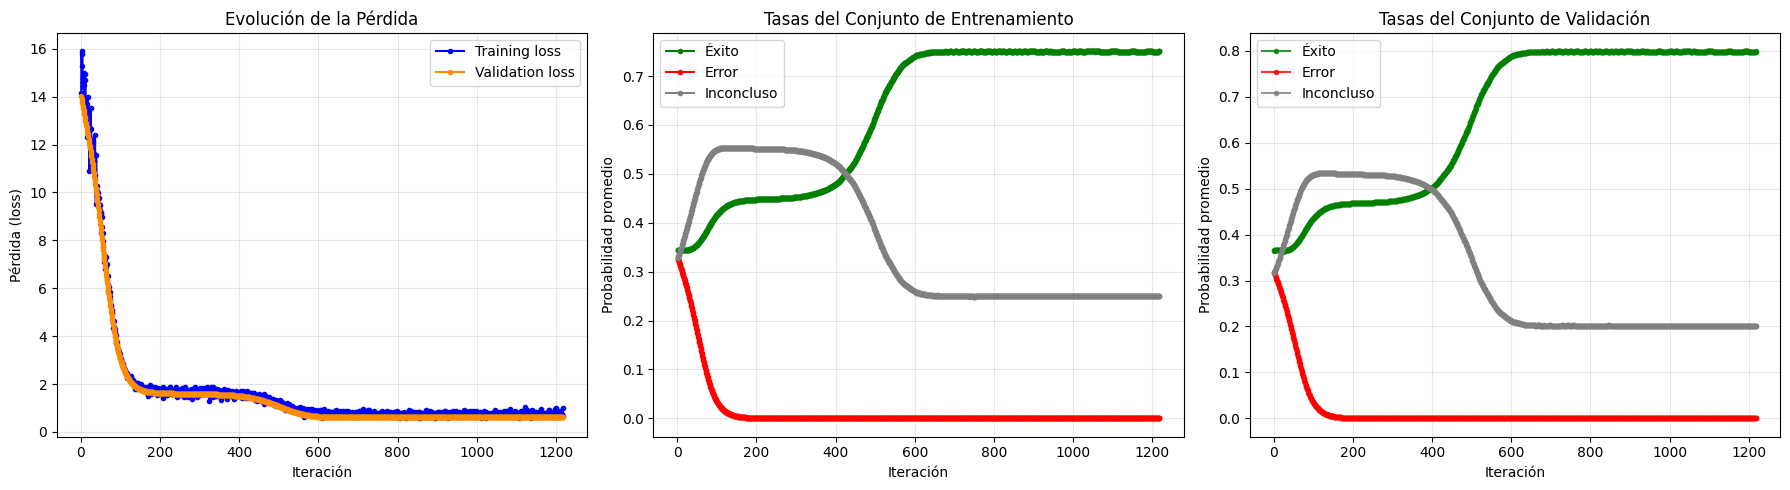

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

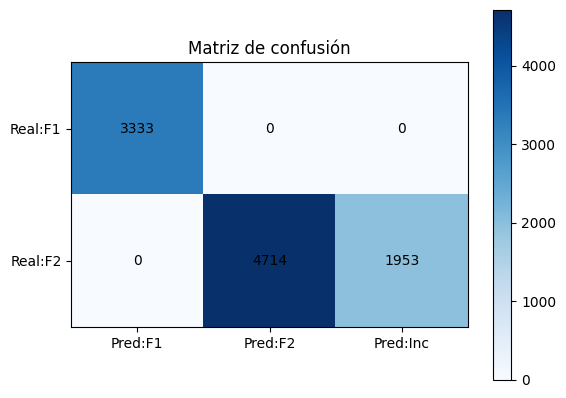

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
